<a href="https://colab.research.google.com/github/zparvez2z/Assemblynimation/blob/master/Multi_Label_Question_Classification_reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO DO

1. Tokenization
2. Lemmatization
3. POS tagging
4. Dependency parsing
5. Question focus identification
6. Concept Identification
    1. SciSpacy(https://spacy.io/universe/project/scispacy)
    2. UTS (https://www.nlm.nih.gov/research/umls/index.html)
7. Choise Identification using regex
8. Quantity identification using regex
9. Semantic dependency parsing (spacy)
10. Semantic head dependency parsing (spacy) !
11. Question type identification ( Factoid, List, Choice, Quantity)
12. Apply SOTA Classification Algo. on final dataset
13. Answer retrival( corpus generation)
14. Answer ranking





**Question: Will multi-level classification(inititially classifying to factoid/list/MC etc then Bio-Medical label) improve multi-label classification accuracy?!**

# Required python modules

In [ ]:
# !pip install -U pip setuptools wheel
# !pip install -U spacy

# !wget https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_scibert-0.4.0.tar.gz
# !pip install en_core_sci_scibert-0.4.0.tar.gz

# !wget https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
# !pip install en_core_sci_lg-0.4.0.tar.gz

# !wget https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz
# !pip install en_ner_craft_md-0.4.0.tar.gz

# !wget https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz
# !pip install en_ner_jnlpba_md-0.4.0.tar.gz

# !wget https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
# !pip install en_ner_bc5cdr_md-0.4.0.tar.gz

# !wget https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
# !pip install en_ner_bionlp13cg_md-0.4.0.tar.gz

# !pip install scispacy
# !pip install swifter
# !pip install scikit-multilearn
# !python -m spacy download en_core_web_sm

     |████████████████████████████████| 89 kB 4.9 MB/s 


In [ ]:
# !python -m spacy download en_core_web_lg

In [ ]:
import pandas as pd
# import scispacy
# import spacy
# from spacy import displacy
# print(spacy.__version__)
# import swifter
# import dask.dataframe as dd
# import multiprocessing
# from dask.multiprocessing import get
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import sys
# nlp = spacy.load('en_core_web_sm')
# import en_core_sci_lg
# nlp_sci_lg = en_core_sci_lg.load()

In [ ]:
# #load all spacy model
# sci_scibert = spacy.load("en_core_sci_scibert")
# sci_lg = spacy.load("en_core_sci_lg")
# ner_craft = spacy.load("en_ner_craft_md")
# ner_jnlpba = spacy.load("en_ner_jnlpba_md")
# ner_bc5cdr = spacy.load("en_ner_bc5cdr_md")
# ner_bionlp13cg = spacy.load("en_ner_bionlp13cg_md")

nlp = spacy.load("en_core_sci_scibert")

# Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data import

In [ ]:
#copy data from drive to colab
# %cp "/content/drive/MyDrive/multi_label_question_classification/data_set_with_semantic_types.csv" "/content/"
# df = pd.read_csv("/content/data_set_with_semantic_types.csv",encoding= 'utf-8')
# df = pd.read_csv("/content/prepared_data.csv",encoding= 'utf-8')
%cp /content/drive/MyDrive/multi_label_question_classification/BioASQ-trainingDataset4b_v1.csv /content
df = pd.read_csv("/content/BioASQ-trainingDataset4b_v1.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   body          1307 non-null   object
 1   documents     1307 non-null   object
 2   triples       1307 non-null   object
 3   ideal_answer  1285 non-null   object
 4   concepts      1285 non-null   object
 5   type          1285 non-null   object
 6   id            1273 non-null   object
 7   snippets      1187 non-null   object
 8   Unnamed: 8    816 non-null    object
dtypes: object(9)
memory usage: 92.0+ KB


In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.info()

# Labels to lower

In [ ]:
df["Labels"] = df["Labels"].str.lower()

In [ ]:
df.sample(5)

,Question,Documents,Ideal_Answer,Exact_Answer,Concept,Labels,class-1,class-2,class-3,class-4,class-5,class-6,class-7,class-8,Question_focus,Semantic_types
40,List symptoms of the IFAP syndrome.,"""http://www.ncbi.nlm.nih.gov/pubmed/25685152"",...","""The IFAP syndrome is a rare X-linked genetic...","[\n ""follicular ichthyosis""\n ...","""http://www.nlm.nih.gov/cgi/mesh/2016/MB_cgi?f...",list,tmtool:Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,List,"['List [inpr]', 'symptoms (Symptoms aspect) [f..."
695,Which are the main NMD factors in Saccharomyce...,"""http://www.ncbi.nlm.nih.gov/pubmed/20675403"",...","""In Saccharomyces cerevisiae, rapid degradatio...","[\n ""Upf1p""\n ], \n [\n...","""http://www.nlm.nih.gov/cgi/mesh/2015/MB_cgi?f...",list,umls:aapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NMD,"['Main (Primary) [qlco]', 'NMD (Nonsense Media..."
479,Which is the main target of the anti-arrhythmi...,"""http://www.ncbi.nlm.nih.gov/pubmed/24858181"",...","""Flecainide is a class 1c antiarrhythmic that ...","""The sodium channel""",http://www.biosemantics.org/jochem#4249323,factoid,umls:bacs,umls:aapp,NaN,NaN,NaN,NaN,NaN,NaN,target,"['Main (Primary) [qlco]', 'Target [ftcn]', 'An..."
68,In which proteins is the chromodomain present?,"""http://www.ncbi.nlm.nih.gov/pubmed/22897906"",...","""The chromodomain (chromatin organizer modifie...","[\n ""HP1 alpha""\n ], \n ...","""http://www.uniprot.org/uniprot/CDYL1_HUMAN"", ...",list,umls:gngm,umls:aapp,NaN,NaN,NaN,NaN,NaN,NaN,proteins,"['PROTEINS (Proteins) [aapp,bacs]', 'PRESENT (..."
582,What is the ubiquitin proteome?,"""http://www.ncbi.nlm.nih.gov/pubmed/23764619"",...","""The ubiquitin proteome is the entire set ubiq...","""The ubiquitin proteome is the entire set ubiq...","""http://www.nlm.nih.gov/cgi/mesh/2014/MB_cgi?f...",factoid,umls:cnce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,proteome,"['Ubiquitin [aapp,bacs]', 'Proteome [aapp,bacs]']"


# Formatting column names

In [ ]:
# set column names
col_names=['No.',	'Question_ID',	'Question',	'Documents',	'Ideal_Answer',	'Exact_Answer',	'Concept',	'Labels',	'class-1',	'class-2',	'class-3',	'class-4',	'class-5','class-6',	'class-7',	'class-8']
df.columns = col_names

In [ ]:
df = df[df['Labels'].notna()]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773 entries, 0 to 780
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   No.           773 non-null    int64 
 1   Question_ID   773 non-null    object
 2   Question      773 non-null    object
 3   Documents     689 non-null    object
 4   Ideal_Answer  696 non-null    object
 5   Exact_Answer  689 non-null    object
 6   Concept       552 non-null    object
 7   Labels        773 non-null    object
 8   class-1       773 non-null    object
 9   class-2       359 non-null    object
 10  class-3       119 non-null    object
 11  class-4       31 non-null     object
 12  class-5       13 non-null     object
 13  class-6       5 non-null      object
 14  class-7       2 non-null      object
 15  class-8       2 non-null      object
dtypes: int64(1), object(15)
memory usage: 102.7+ KB


In [ ]:
# drop No. and Question_id
df.drop(['No.', 'Question_ID'], axis=1,inplace=True)

# EDA

## Labels

In [ ]:
#What to do with these data points ?
df[df['class-5'].notnull()]

In [ ]:
df['Labels'].value_counts()

factoid    409
list       361
Name: Labels, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


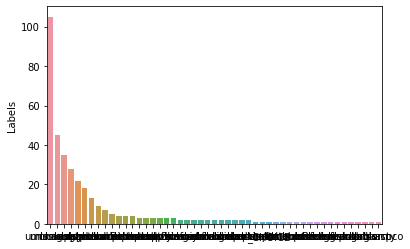

In [ ]:
sns.barplot(df['Labels'].value_counts().index,df['Labels'].value_counts())

## class

In [ ]:
df['class-1'].value_counts()

umls:gngm    77
umls:dsyn    71
umls:enzy    64
umls:bacs    39
umls:sosy    39
             ..
umls:elii     1
umls:tmco     1
umls:dora     1
umls:geoa     1
umls:popg     1
Name: class-1, Length: 71, dtype: int64

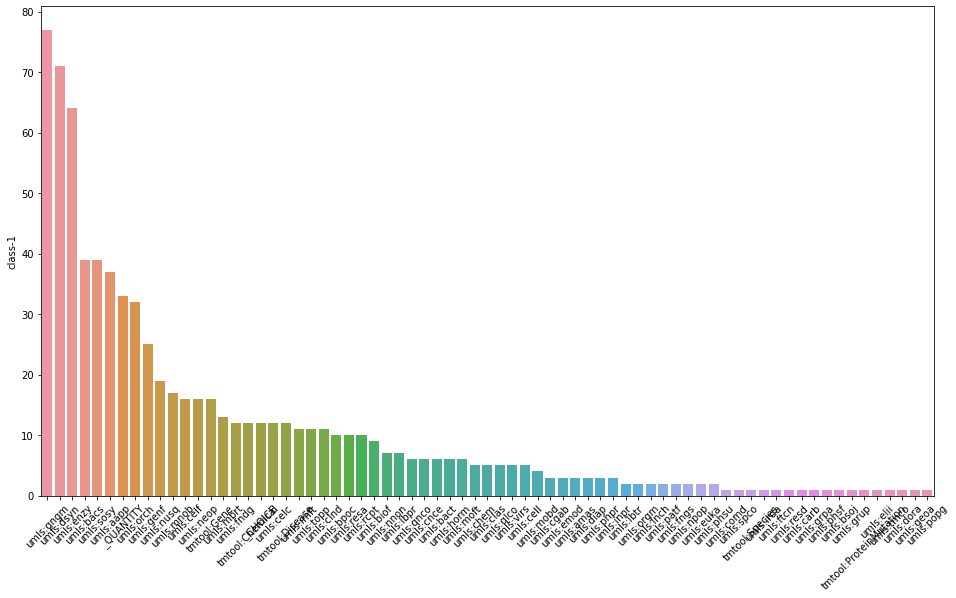

In [ ]:
a4_dims = (16, 9)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)
sns.barplot(df['class-1'].value_counts().index,df['class-1'].value_counts(),ax=ax)

In [ ]:
df[df['class-1'].str.contains("HSP20")]

In [ ]:
df[df['class-1'].str.contains("http")]

In [ ]:
df['class-2'].value_counts()

umls:aapp          105
umls:gngm           45
umls:dsyn           35
umls:qnco           28
umls:phsu           22
umls:clnd           18
umls:bacs           13
umls:rcpt            9
umls:orch            7
tmtool:Disease       5
umls:nusq            4
umls:mobd            4
umls:phpr            4
umls:sosy            3
tmtool:Chemical      3
umls:enzy            3
umls:topp            3
umls:tisu            3
umls:biof            3
umls:neop            2
umls:diap            2
umls:tmco            2
umls:comd            2
umls:bact            2
umls:clas            2
umls:imft            2
umls:elii            2
umls:genf            2
umls:qlco            2
umls:orgm            2
umls:clna            1
umls:fngs            1
umls:orga            1
umls:antb            1
umls:orgf            1
umls:chem            1
umls:patf            1
umls:cnce            1
_CHOICE              1
umls:humn            1
umls:acty            1
umls:spco            1
umls:bpoc            1
umls:blor  

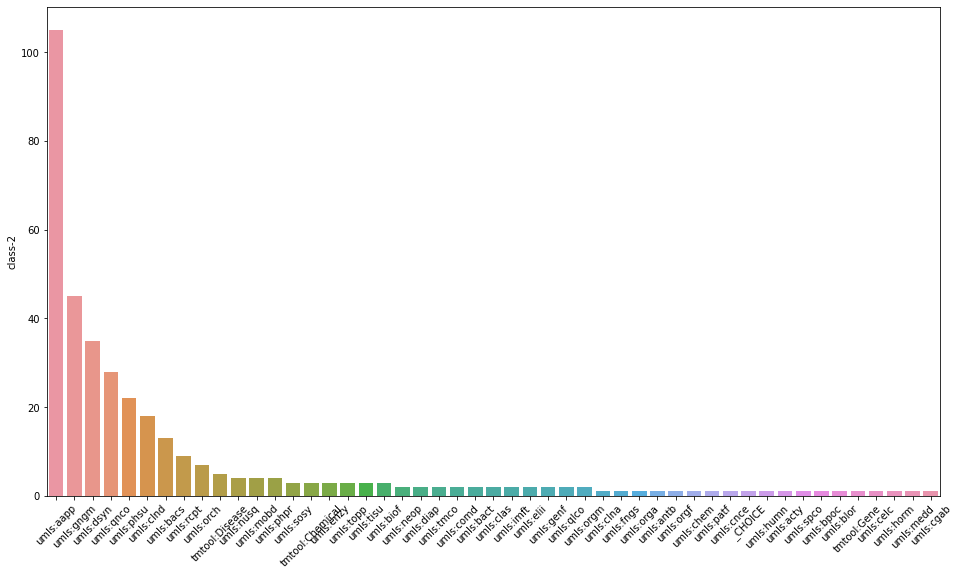

In [ ]:
a4_dims = (16, 9)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)
sns.barplot(df['class-2'].value_counts().index,df['class-2'].value_counts(),ax=ax)

In [ ]:
df['class-3'].value_counts()

umls:aapp         53
umls:phsu         23
umls:gngm         11
umls:bacs          6
umls:dsyn          6
umls:clnd          5
tmtool:Disease     1
umls:food          1
umls:enzy          1
umls:lbpr          1
umls:neop          1
umls:mbrt          1
umls:nusq          1
umls:qnco          1
umls:orgf          1
umls:inpo          1
umls:bdsu          1
umls:moft          1
umls:cgab          1
umls:mobd          1
Name: class-3, dtype: int64

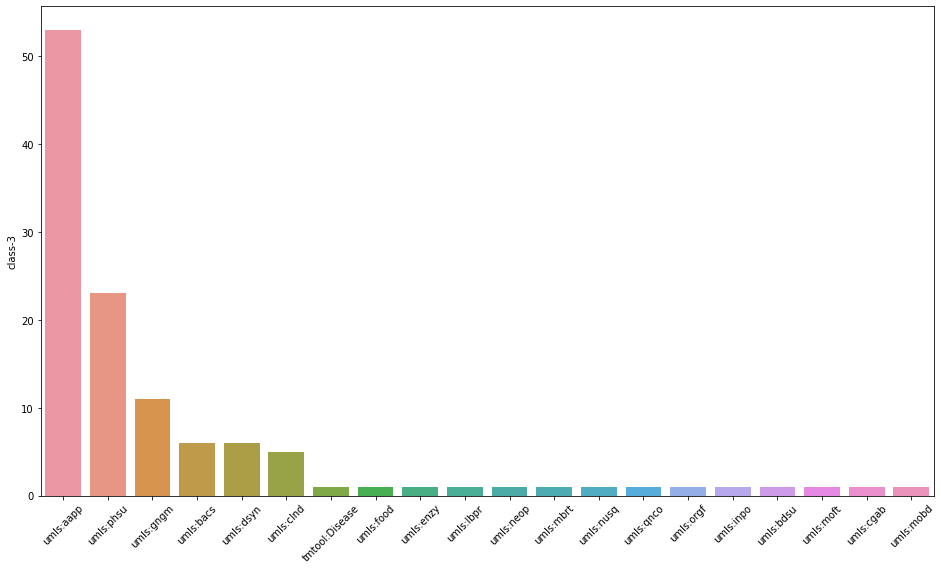

In [ ]:
a4_dims = (16, 9)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)
sns.barplot(df['class-3'].value_counts().index,df['class-3'].value_counts(),ax=ax)

In [ ]:
df['class-4'].value_counts()

umls:aapp    10
umls:phsu     9
umls:gngm     2
umls:bacs     2
umls:mobd     1
umls:orga     1
umls:geoa     1
umls:dsyn     1
umls:topp     1
umls:neop     1
umls:bpoc     1
Name: class-4, dtype: int64

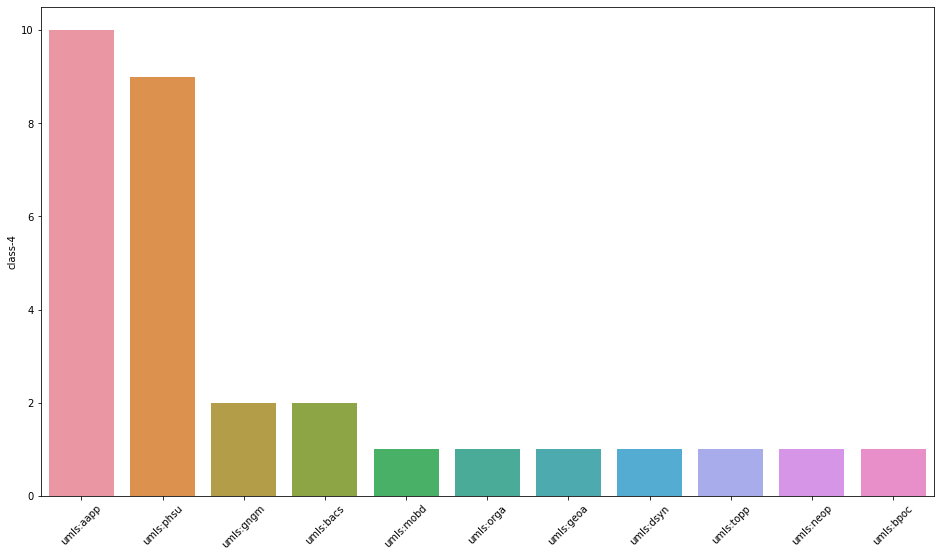

In [ ]:
a4_dims = (16, 9)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)
sns.barplot(df['class-4'].value_counts().index,df['class-4'].value_counts(),ax=ax)

In [ ]:
df['class-5'].value_counts()

umls:aapp    4
umls:dsyn    3
umls:phsu    2
umls:rcpt    1
umls:diap    1
umls:tmco    1
Name: class-5, dtype: int64

In [ ]:
df['class-6'].value_counts()

umls:aapp    4
umls:dsyn    3
umls:phsu    2
umls:rcpt    1
umls:diap    1
umls:tmco    1
Name: class-5, dtype: int64

In [ ]:
df['class-7'].value_counts()

umls:topp    1
umls:phsu    1
Name: class-7, dtype: int64

In [ ]:
df['class-8'].value_counts()

umls:aapp    1
umls:hlca    1
Name: class-8, dtype: int64

In [ ]:
for idx, value in enumerate(df['Question']):
  # print("Question lemma:{}".format(df['Question'].iloc[idx]))
  print(df['Question'].iloc[idx],df['class-1'].iloc[idx],df['class-2'].iloc[idx],df['class-3'].iloc[idx],df['class-4'].iloc[idx])
  # print(value)

In [ ]:
df[['class-1','class-2']].iloc[5]

class-1    umls:neop
class-2          NaN
Name: 5, dtype: object

# Data correction

## Label correction

In [ ]:
df['Labels'].loc[671] = 'factoid'
df.drop(df[df['Labels'] == 'summary'].index,inplace=True)

## Class data correction

In [ ]:
df.drop(df[df['class-1'].str.contains("HSP20")].index,inplace=True)
df['class-1'].loc[df[df['class-1'].str.contains("http")].index] = 'umls:lbpr'

## Question data correction

In [ ]:
df['Question'][0] = 'List signaling molecules (ligands) that interact with the receptor EGFR'

In [ ]:
df['Question'][4] = "List human genes encoding for the dishevelled proteins"

In [ ]:
df['Question'][57] = 'List genes that have been found mutated in CMT1A'

In [ ]:
df['Question'][85] = 'The protein NONO forms heterodimers With which proteins ?'

# Tokenization

Tokenization

Tokenization allows you to identify the basic units in your text. These basic units are called tokens. Tokenization is useful because it breaks a text into meaningful units. These units are used for further analysis, like part of speech tagging.

# Lemmatization

Lemmatization

Lemmatization is the process of reducing inflected forms of a word while still ensuring that the reduced form belongs to the language. This reduced form or root word is called a lemma.

For example, organizes, organized and organizing are all forms of organize. Here, organize is the lemma. The inflection of a word allows you to express different grammatical categories like tense (organized vs organize), number (trains vs train), and so on. Lemmatization is necessary because it helps you reduce the inflected forms of a word so that they can be analyzed as a single item. It can also help you normalize the text.

In [ ]:
def get_lemma(question):
    try:
      doc = nlp(str(question))
      lemmetized = ' '.join([n.lemma_ for n in doc])
      return lemmetized
    except:
      return None

In [ ]:
df['Question_lemma'] = df['Question'].swifter.apply(lambda row : get_lemma(row))

Pandas Apply:   0%|          | 0/773 [00:00<?, ?it/s]

In [ ]:
df[['Question','Question_lemma']].to_csv("Qs&leamma.csv")

# POS tagging

Part of speech or POS is a grammatical role that explains how a particular word is used in a sentence. There are eight parts of speech:

    Noun
    Pronoun
    Adjective
    Verb
    Adverb
    Preposition
    Conjunction
    Interjection

Part of speech tagging is the process of assigning a POS tag to each token depending on its usage in the sentence. POS tags are useful for assigning a syntactic category like noun or verb to each word.



In [ ]:
def get_pos_tag(question):
    try:
      doc = nlp(str(question))
      pos_tagged = ' '.join([n.tag_ for n in doc])
      return pos_tagged
    except:
      return None

In [ ]:
df['Question_pos_tag'] = df['Question'].swifter.apply(lambda row : get_pos_tag(row))

Pandas Apply:   0%|          | 0/773 [00:00<?, ?it/s]

In [ ]:
df[['Question','Question_pos_tag']].to_csv("Qs&pos.csv")

# Choice identification

In [ ]:
def is_choice(question):
  try:    
    doc = nlp(question)    
    if doc[0].lemma_ == 'be':
      # print(question)
      return 1
    
    for token in doc:
      if token.lemma_ == 'or':
        # print(question)
        return 1
    
    return 0

  except:
    return None

In [ ]:
df['Is_choice'] = df['Question'].swifter.apply(lambda row : is_choice(row))

Pandas Apply:   0%|          | 0/773 [00:00<?, ?it/s]

In [ ]:
df['Is_choice'].value_counts()

0    751
1     22
Name: Is_choice, dtype: int64

In [ ]:
df[['Question','Is_choice']].to_csv("Qs&choice.csv")

# Quantity identification

In [ ]:
from spacy.matcher import PhraseMatcher
phrase_matcher = PhraseMatcher(nlp.vocab)

def is_quantity(question):
  try:
    phrases = ['how many', 'how much', 'how large', 'how long', 'diameter', 'value','rate', 
               'percentage', 'incidence', 'prevalence', 'proportion', 'number']
    patterns = [nlp(text) for text in phrases]
    phrase_matcher.add('Quantity', None, *patterns)    
    sentence = nlp(question)
    matched_phrases = phrase_matcher(sentence)
    if matched_phrases:
      print(question)
      return 1
    
    return 0
  
  except:
    return None      

In [ ]:
df['Is_quantity'] = df['Question'].swifter.apply(lambda row : is_quantity(row))

Pandas Apply:   0%|          | 0/773 [00:00<?, ?it/s]

What is the number of long non coding RNAs in the human genome
What is the number of protein coding genes in the human genome?
What is the proportion of non canonical splice sites in the human genome?
What is the incidence of Edwards syndrom in the european population?
What is the rate of survival after commotio cordis?
What is the percentage of responders to tetrabenazine treatment for dystonia in children?
What is the typical outer diameter of microtubules (tubulin heterodimers)?
What is the average diameter of intermediate filaments?
In what proportion of children with heart failure has Enalapril been shown to be safe and effective?
Which is the prevalence of cystic fibrosis in the human population?
Approximately how many recombination hotspots have been found in the yeast genome?
What is the incidence of cystic fibrosis in the caucasian population?
What is the incidence of sudden cardiac death among young athletes?
What is the prevalence of short QT syndrome?
Which value of nuchal 

In [ ]:
df['Is_quantity'].value_counts()

0    757
1     16
Name: Is_quantity, dtype: int64

In [ ]:
df[['Question','Is_quantity']].to_csv("Qs&qntt.csv")

# Dependency parsing

Dependency parsing

Dependency parsing is the process of extracting the dependency parse of a sentence to represent its grammatical structure. It defines the dependency relationship between headwords and their dependents. The head of a sentence has no dependency and is called the root of the sentence. The verb is usually the head of the sentence. All other words are linked to the headword.

The dependencies can be mapped in a directed graph representation:

    Words are the nodes.
    The grammatical relationships are the edges.

Dependency parsing helps you know what role a word plays in the text and how different words relate to each other. It’s also used in shallow parsing and named entity recognition.


# code

In [ ]:
# # nlp = spacy.load('en_core_web_sm')

# tokens = []
# lemma = []
# pos = []
# dep = []
# # for doc in nlp.pipe(df['species'].astype('unicode').values '''batch_size=50,n_threads=3'''):
# for doc in nlp.pipe(df['Question'].astype('unicode').values ):
#     if doc.is_parsed:
#         tokens.append([n.text for n in doc])
#         lemma.append([n.lemma_ for n in doc])
#         pos.append([n.tag_ for n in doc])
#         dep.append([n.dep_ for n in doc])
#     else:
#         # We want to make sure that the lists of parsed results have the
#         # same number of entries of the original Dataframe, so add some blanks in case the parse fails
#         tokens.append(None)
#         lemma.append(None)
#         pos.append(None)
#         dep.append(None)

# df['Question_tokens'] = tokens
# df['Question_lemma'] = lemma
# df['Question_pos'] = pos
# df['Question_dep'] = dep


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if __name__ == '__main__':


In [ ]:
# ddata = dd.from_pandas(df, npartitions=8)
# lemma = ddata.map_partitions(lambda df : df.apply(( lambda row : get_lemma(row.Question)) , axis=1)).compute(scheduler='processes')

# len(lemma)

773

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773 entries, 0 to 780
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Question        773 non-null    object
 1   Documents       689 non-null    object
 2   Ideal_Answer    696 non-null    object
 3   Exact_Answer    689 non-null    object
 4   Concept         552 non-null    object
 5   Labels          773 non-null    object
 6   class-1         773 non-null    object
 7   class-2         359 non-null    object
 8   class-3         119 non-null    object
 9   class-4         31 non-null     object
 10  class-5         13 non-null     object
 11  class-6         5 non-null      object
 12  class-7         2 non-null      object
 13  class-8         2 non-null      object
 14  Question_lemma  773 non-null    object
dtypes: object(15)
memory usage: 116.6+ KB


In [ ]:
# df[['Question','Question_tokens','Question_lemma','Question_pos','Question_dep']].sample(5)

# Dependency Visualization

In [ ]:

# nlp = spacy.load("en_core_web_sm")
doc = nlp("List genes that have been found mutated in CMT1A")

for token in doc:
    print("token:{}--->{} ".format(token.text,[child for child in token.children]))

token:List--->[] 
token:genes--->[List, found] 
token:that--->[] 
token:have--->[] 
token:been--->[] 
token:found--->[that, have, been, mutated] 
token:mutated--->[CMT1A] 
token:in--->[] 
token:CMT1A--->[in] 


In [ ]:
# %%writefile de_viz.py

import spacy
from spacy import displacy
print(spacy.__version__)

# nlp = spacy.load('en_core_web_sm')
# doc = nlp("List signaling molecules (ligands) that interact with the receptor EGFR?")
doc = nlp("Which thyroid hormone transporter be implicate in thyroid hormone resistence syndrome?")
displacy.render(doc,jupyter=True, style="dep")

3.0.7


In [ ]:
doc = nlp('List signaling molecules (ligands) that interact with the receptor EGFR?')
displacy.render(doc,jupyter=True, style="dep")

# Others

In [ ]:
droot_count= 0
for idx,deps in enumerate(df['Question_dep']):
  if deps.count('ROOT') > 1:
    print(idx)
    droot_count+=1

print(droot_count)

0
1


In [ ]:
listq_count= 0
listq_idx = []
for idx,question in enumerate(df['Question']):
  doc = nlp(question)
  tokens = [n.text for n in doc]
  if tokens[0].lower()=='list':
    print(idx,tokens)
    listq_count+=1
    listq_idx.append(idx)


print(listq_count)
print(listq_idx)

0 ['List', 'signaling', 'molecules', '(', 'ligands', ')', 'that', 'interact', 'with', 'the', 'receptor', 'EGFR', '?']
4 ['List', 'the', 'human', 'genes', 'encoding', 'for', 'the', 'dishevelled', 'proteins', '?']
17 ['List', 'the', 'endoscopic', 'diagnoses', 'that', 'have', 'been', 'reported', 'in', 'children', 'with', 'autism']
21 ['List', 'Hemolytic', 'Uremic', 'Syndrome', 'Triad', '.']
35 ['List', 'side', 'effects', 'of', 'SGLT2', 'inhibitors', '?']
38 ['List', 'symptoms', 'of', 'the', 'IFAP', 'syndrome', '.']
41 ['List', 'two', 'common', 'features', 'of', 'Tay', 'syndrome', '.']
55 ['List', 'genes', 'that', 'have', 'been', 'found', 'mutated', 'in', 'CMT1A']
63 ['List', 'symptoms', 'of', '4H', 'leukodystrophy', '.']
74 ['List', 'markers', 'for', 'autophagy', '.']
86 ['List', 'human', 'proteins', 'that', 'are', 'subject', 'to', 'a', 'dimer', '-', 'to', '-', 'tetramer', 'transition', '.']
11
[0, 4, 17, 21, 35, 38, 41, 55, 63, 74, 86]


# focus identification

In [ ]:
def get_root(doc):
  # q_root = [n.lemma_ for n in doc if n.dep_ == 'ROOT']
  q_root = [n for n in doc if n.dep_ == 'ROOT']
  # print("root word:{}".format(q_root[0].lemma_))
  return q_root[0]

def focus_extraction(question):
  try:
    noun_pos_tag_list=['NN','NNP','NNS','NNPS']
    # noun_pos_tag_list=['NN','NNP','NNS','NNPS','VB']# added VERB

    focus = None
    # parsedQuestionTokens=[]
    doc = nlp(question)
    root = get_root(doc)
    
    for token in doc:
      # parsedQuestionTokens.append(token.text)
      if token.head != None:
        if token.head.lemma_ == root.lemma_ and token.tag_ in noun_pos_tag_list:
          focus = token
          # print("question focus:{}".format(focus.lemma_))
          break

      if doc[0].lemma_ == 'list':
        if focus != None or focus.lemma_ == 'list':
          focus = root
          # print("focus (list question): {}".format(focus))
    # print("focus:{}".format(focus))
    return focus
  except Exception:
    # print(traceback.format_exc())
    return None

In [ ]:
df['Question_focus'] = df['Question'].swifter.apply(lambda row : focus_extraction(row))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 0 to 780
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Question        770 non-null    object
 1   Documents       688 non-null    object
 2   Ideal_Answer    695 non-null    object
 3   Exact_Answer    688 non-null    object
 4   Concept         551 non-null    object
 5   Labels          770 non-null    object
 6   class-1         770 non-null    object
 7   class-2         358 non-null    object
 8   class-3         118 non-null    object
 9   class-4         30 non-null     object
 10  class-5         12 non-null     object
 11  class-6         5 non-null      object
 12  class-7         2 non-null      object
 13  class-8         2 non-null      object
 14  Question_focus  723 non-null    object
dtypes: object(15)
memory usage: 116.2+ KB


In [ ]:
df["Question_focus"].isna().sum()

47

In [ ]:
df.to_csv("dataset_with_focus.csv")

In [ ]:
%cp -v /content/dataset_with_focus.csv /content/drive/MyDrive/multi_label_question_classification

'/content/dataset_with_focus.csv' -> '/content/drive/MyDrive/multi_label_question_classification/dataset_with_focus.csv'


In [ ]:
df[['Question','Question_focus']].to_csv("Qs&focus.csv")

In [ ]:
df[df["Question_focus"].isna()]

In [ ]:
focus = focus_extraction("Which thyroid hormone transporter be implicate in thyroid hormone resistence syndrome?")
print(type(focus))
print("focus:{}".format(focus))

In [ ]:
focus = focus_extraction("List human genes encoding for the dishevelled proteins")
print("focus:{}".format(focus))

focus:List


In [ ]:
focus = focus_extraction("List symptoms of the IFAP syndrome")
print("focus:{}".format(focus))

focus:None


In [ ]:
focus = focus_extraction("list signaling molecules (ligands) that interact with the receptor EGFR")
print("focus:{}".format(focus))

focus:list


# Concept Identification

Concept Identification

In [ ]:
# df.drop(['Question_concepts'], axis=1,inplace=True)

In [ ]:
from ast import literal_eval
import re

In [ ]:
semantic_types = []

for item in df['Semantic_types']:
  semantic_types.append(literal_eval(item))

df['Semantic_types'] = semantic_types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Question        770 non-null    object
 1   Documents       688 non-null    object
 2   Ideal_Answer    695 non-null    object
 3   Exact_Answer    688 non-null    object
 4   Concept         551 non-null    object
 5   Labels          770 non-null    object
 6   class-1         770 non-null    object
 7   class-2         358 non-null    object
 8   class-3         118 non-null    object
 9   class-4         30 non-null     object
 10  class-5         12 non-null     object
 11  class-6         5 non-null      object
 12  class-7         2 non-null      object
 13  class-8         2 non-null      object
 14  Question_focus  723 non-null    object
 15  Semantic_types  770 non-null    object
dtypes: object(16)
memory usage: 96.4+ KB


In [ ]:
df.dropna(subset = ['Question_focus'], inplace=True)
df['Question_focus'].isna().sum()

0

In [ ]:
df.drop(df[df['Question_focus'] == 'List'].index,inplace=True)
df[df['Question_focus'] == 'List']

,Question,Documents,Ideal_Answer,Exact_Answer,Concept,Labels,class-1,class-2,class-3,class-4,class-5,class-6,class-7,class-8,Question_focus,Semantic_types


In [ ]:
df[['Question_focus','Semantic_types']]

In [ ]:
focus= df['Question_focus'][1]
semantic_types = df['Semantic_types'][1]

In [ ]:
for sem_type in semantic_types:
  if focus in sem_type:
    concept_sem_type = re.findall('\[.*?\]',sem_type)
    print(concept_sem_type[0][1:-1])

aapp,bacs
aapp,bacs


In [ ]:

concept_sem_type = []
for idx in df.index:
  focus= df['Question_focus'][idx]
  semantic_types = df['Semantic_types'][idx]
  
  sem_set = set() 
  for sem_type in semantic_types:
    if focus.lower() in sem_type.lower():      
      match = re.findall('\[.*?\]',sem_type)
      # concept_sem_type.append(match[0][1:-1].split(','))
      # match = set(match[0][1:-1].split(','))
      match = match[0][1:-1].split(',')
      sem_set.update(match)
  concept_sem_type.append(sem_set)

concept_sem_type

In [ ]:
df['Concept_sem_type'] = concept_sem_type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 1 to 769
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Question          682 non-null    object
 1   Documents         608 non-null    object
 2   Ideal_Answer      615 non-null    object
 3   Exact_Answer      608 non-null    object
 4   Concept           492 non-null    object
 5   Labels            682 non-null    object
 6   class-1           682 non-null    object
 7   class-2           321 non-null    object
 8   class-3           101 non-null    object
 9   class-4           26 non-null     object
 10  class-5           10 non-null     object
 11  class-6           4 non-null      object
 12  class-7           1 non-null      object
 13  class-8           1 non-null      object
 14  Question_focus    682 non-null    object
 15  Semantic_types    682 non-null    object
 16  Concept_sem_type  682 non-null    object
dtypes: object(17)
me

In [ ]:
df.drop(df[df['Concept_sem_type'] == set()].index,inplace=True)

In [ ]:
df[df['Concept_sem_type'] == set()]

,Question,Documents,Ideal_Answer,Exact_Answer,Concept,Labels,class-1,class-2,class-3,class-4,class-5,class-6,class-7,class-8,Question_focus,Semantic_types,Concept_sem_type


In [ ]:
df2 = pd.DataFrame(df.Concept_sem_type.values.tolist()).add_prefix('sem_')

In [ ]:
df2[['class-1','class-2','class-3','class-4','class-5','class-6','class-7','class-8']] = df[['class-1','class-2','class-3','class-4','class-5','class-6','class-7','class-8']].values

In [ ]:
%cp  /content/drive/MyDrive/multi_label_question_classification/sem_types_and_class.csv /content

In [ ]:
df2 = pd.read_csv("sem_types_and_class.csv")
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sem_0    605 non-null    object
 1   sem_1    319 non-null    object
 2   sem_2    96 non-null     object
 3   sem_3    26 non-null     object
 4   sem_4    8 non-null      object
 5   sem_5    1 non-null      object
 6   class-1  605 non-null    object
 7   class-2  288 non-null    object
 8   class-3  89 non-null     object
 9   class-4  20 non-null     object
 10  class-5  8 non-null      object
 11  class-6  4 non-null      object
 12  class-7  1 non-null      object
 13  class-8  1 non-null      object
dtypes: object(14)
memory usage: 66.3+ KB


In [ ]:
sem_dict = {'aapp':116,'acab':20,'acty':52,'aggp':100,'amas':87,'amph':11,'anab':190,'anim':8,'anst':17,
            'antb':195,'arch':194,'bacs':123,'bact':7,'bdsu':31,'bdsy':22,'bhvr':53,'biof':38,'bird':12,
            'blor':29,'bmod':91,'bodm':122,'bpoc':23,'bsoj':30,'celc':26,'celf':43,'cell':25,'cgab':19,
            'chem':103,'chvf':120,'chvs':104,'clas':185,'clna':201,'clnd':200,'cnce':77,'comd':49,'crbs':88,
            'diap':60,'dora':56,'drdd':203,'dsyn':47,'edac':65,'eehu':69,'elii':196,'emod':50,'emst':18,
            'enty':71,'enzy':126,'euka':204,'evnt':51,'famg':99,'ffas':21,'fish':13,'fndg':33,'fngs':4,'food':168,
            'ftcn':169,'genf':45,'geoa':83,'gngm':28,'gora':64,'grpa':102,'grup':96,'hcpp':68,'hcro':93,'hlca':58,
            'hops':131,'horm':125,'humn':16,'idcn':78,'imft':129,'inbe':55,'inch':197,'inpo':37,'inpr':170,
            'irda':130,'lang':171,'lbpr':59,'lbtr':34,'mamm':15,'mbrt':63,'mcha':66,'medd':74,'menp':41,
            'mnob':73,'mobd':48,'moft':44,'mosq':85,'neop':191,'nnon':114,'npop':70,'nusq':86,'ocac':57,
            'ocdi':90,'orch':109,'orga':32,'orgf':40,'orgm':1,'orgt':92,'ortf':42,'patf':46,'phob':72,
            'phpr':67,'phsf':39,'phsu':121,'plnt':2,'podg':101,'popg':98,'prog':97,'pros':94,'qlco':80,
            'qnco':81,'rcpt':192,'rept':14,'resa':62,'resd':75,'rnlw':89,'sbst':167,'shro':95,'socb':54,
            'sosy':184,'spco':82,'tisu':24,'tmco':79,'topp':61,'virs':5,'vita':127,'vtbt':10}

In [ ]:
df2.replace({"sem_0": sem_dict,"sem_1": sem_dict,"sem_2": sem_dict,"sem_3": sem_dict,"sem_4": sem_dict,"sem_5": sem_dict},inplace=True)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sem_0    605 non-null    object 
 1   sem_1    319 non-null    float64
 2   sem_2    96 non-null     float64
 3   sem_3    26 non-null     float64
 4   sem_4    8 non-null      float64
 5   sem_5    1 non-null      float64
 6   class-1  605 non-null    object 
 7   class-2  288 non-null    object 
 8   class-3  89 non-null     object 
 9   class-4  20 non-null     object 
 10  class-5  8 non-null      object 
 11  class-6  4 non-null      object 
 12  class-7  1 non-null      object 
 13  class-8  1 non-null      object 
dtypes: float64(5), object(9)
memory usage: 66.3+ KB


In [ ]:
df2.drop(df2[df2['sem_0'] == 'Publication Type'].index, inplace = True)
df2.drop(df2[df2['sem_0'] == 'MoA'].index, inplace = True) 
df2.drop(df2[df2['sem_0'] == '18F'].index, inplace = True) 
df2.drop(df2[df2['sem_0'] == 'EPC'].index, inplace = True) 

# df.drop(df[df['Age'] < 25].index, inplace = True)

In [ ]:
# df2.rename(columns={"class-1": "class"}, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 604
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sem_0    600 non-null    object 
 1   sem_1    316 non-null    float64
 2   sem_2    95 non-null     float64
 3   sem_3    26 non-null     float64
 4   sem_4    8 non-null      float64
 5   sem_5    1 non-null      float64
 6   class-1  600 non-null    object 
 7   class-2  283 non-null    object 
 8   class-3  86 non-null     object 
 9   class-4  20 non-null     object 
 10  class-5  8 non-null      object 
 11  class-6  4 non-null      object 
 12  class-7  1 non-null      object 
 13  class-8  1 non-null      object 
dtypes: float64(5), object(9)
memory usage: 70.3+ KB


In [ ]:
df2[df2.columns[:6]] = df2[df2.columns[:6]].fillna(value=0)

In [ ]:
df2

,sem_0,sem_1,sem_2,sem_3,sem_4,sem_5,class-1,class-2,class-3,class-4,class-5,class-6,class-7,class-8
0,116,123.0,74.0,0.0,0.0,0.0,umls:enzy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,114,123.0,0.0,0.0,0.0,0.0,umls:nusq,umls:gngm,NaN,NaN,NaN,NaN,NaN,NaN
2,121,0.0,0.0,0.0,0.0,0.0,umls:orch,umls:clnd,umls:phsu,NaN,NaN,NaN,NaN,NaN
3,80,170.0,0.0,0.0,0.0,0.0,umls:neop,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,170,58.0,0.0,0.0,0.0,0.0,umls:clas,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,80,0.0,0.0,0.0,0.0,0.0,umls:sosy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,121,0.0,0.0,0.0,0.0,0.0,umls:clnd,umls:phsu,umls:aapp,NaN,NaN,NaN,NaN,NaN
602,81,0.0,0.0,0.0,0.0,0.0,umls:resa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,80,0.0,0.0,0.0,0.0,0.0,umls:qnco,umls:clnd,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df2[df2.columns[6:]]

,class-1,class-2,class-3,class-4,class-5,class-6,class-7,class-8
0,umls:enzy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,umls:nusq,umls:gngm,NaN,NaN,NaN,NaN,NaN,NaN
2,umls:orch,umls:clnd,umls:phsu,NaN,NaN,NaN,NaN,NaN
3,umls:neop,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,umls:clas,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
600,umls:sosy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,umls:clnd,umls:phsu,umls:aapp,NaN,NaN,NaN,NaN,NaN
602,umls:resa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,umls:qnco,umls:clnd,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# t2 = pd.get_dummies(df2[df2.columns[6:]],prefix='')
# t2 = t2.groupby(t2.columns, axis=1).sum()
for column in t2.columns:
  print(t2[column].value_counts()[1] >= 20)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


features = df2[df2.columns[:6]].values


for column in t2.columns:
  if t2[column].value_counts()[1] >= 20:
    print("Class name: {}".format(column))
    print("no of instances {}".format(t2[column].value_counts()[1]))
    labels = t2[column].values
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0)

    models = [
        # RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        RandomForestClassifier(),
        LinearSVC(),
        MultinomialNB(),
        LogisticRegression(),
        KNeighborsClassifier()
    ]
    CV = 10
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
      model_name = model.__class__.__name__
      print("model name:{}".format(model_name))
      X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=0)
      model.fit(X_train, y_train)
      print("score on test: " + str(model.score(X_test, y_test)))
      print("score on train: "+ str(model.score(X_train, y_train)))
      y_pred = model.predict(X_test)
      conf_mat = confusion_matrix(y_test, y_pred)
      print(conf_mat)

    print("--------------------------------------------------------")



Class name: __QUANTITY
no of instances 27
model name:RandomForestClassifier
score on test: 0.9625
score on train: 0.9666666666666667
[[229   3]
 [  6   2]]
model name:LinearSVC
score on test: 0.8
score on train: 0.8166666666666667
[[192  40]
 [  8   0]]
model name:MultinomialNB
score on test: 0.4875
score on train: 0.4111111111111111
[[109 123]
 [  0   8]]
model name:LogisticRegression
score on test: 0.9666666666666667
score on train: 0.9472222222222222
[[232   0]
 [  8   0]]
model name:KNeighborsClassifier
score on test: 0.9625
score on train: 0.9611111111111111
[[229   3]
 [  6   2]]
--------------------------------------------------------
Class name: _umls:aapp
no of instances 170
model name:RandomForestClassifier
score on test: 0.7875
score on train: 0.8777777777777778
[[152  20]
 [ 31  37]]
model name:LinearSVC
score on test: 0.7208333333333333
score on train: 0.7083333333333334
[[172   0]
 [ 67   1]]
model name:MultinomialNB
score on test: 0.625
score on train: 0.6694444444444444

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

features = df2[df2.columns[:6]].values


for column in t2.columns:
  if t2[column].value_counts()[1] >= 20:
    labels = t2[column].values
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0)

    models = [
        # RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        RandomForestClassifier(),
        LinearSVC(),
        MultinomialNB(),
        LogisticRegression(),
        KNeighborsClassifier()
    ]
    CV = 10
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV,n_jobs=5)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    # import seaborn as sns
    # sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    # sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
    #               size=8, jitter=True, edgecolor="gray", linewidth=2)
    # plt.show()
    print("Feature name: {}".format(column))
    print("no of instances {}".format(t2[column].value_counts()[1]))
    print(cv_df.groupby('model_name').accuracy.mean())

Feature name: __QUANTITY
no of instances 27
model_name
KNeighborsClassifier      0.955000
LinearSVC                 0.935000
LogisticRegression        0.955000
MultinomialNB             0.453333
RandomForestClassifier    0.960000
Name: accuracy, dtype: float64
Feature name: _umls:aapp
no of instances 170
model_name
KNeighborsClassifier      0.790000
LinearSVC                 0.646667
LogisticRegression        0.710000
MultinomialNB             0.675000
RandomForestClassifier    0.796667
Name: accuracy, dtype: float64
Feature name: _umls:bacs
no of instances 49
model_name
KNeighborsClassifier      0.906667
LinearSVC                 0.868333
LogisticRegression        0.918333
MultinomialNB             0.656667
RandomForestClassifier    0.908333
Name: accuracy, dtype: float64
Feature name: _umls:clnd
no of instances 25
model_name
KNeighborsClassifier      0.970000
LinearSVC                 0.896667
LogisticRegression        0.956667
MultinomialNB             0.701667
RandomForestClassifie

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

for n_data in range(41):

  f_df = df2.groupby('class-1').filter(lambda x : len(x) > n_data)
  n_class = f_df['class-1'].nunique()
  encoder = LabelEncoder()
  encoded_values = encoder.fit_transform(f_df["class-1"].values)
  f_df["class_id"] = pd.Series(encoded_values, index=f_df.index)
  features = f_df[f_df.columns[:6]].values
  labels = f_df['class_id'].values
  X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0)

  models = [
      RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
      LinearSVC(),
      MultinomialNB(),
      LogisticRegression(multi_class='multinomial',random_state=0),
      OneVsRestClassifier(SVC())
  ]
  CV = 5
  cv_df = pd.DataFrame(index=range(CV * len(models)))
  entries = []
  for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
      entries.append((model_name, fold_idx, accuracy))
  cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
  # import seaborn as sns
  # sns.boxplot(x='model_name', y='accuracy', data=cv_df)
  # sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
  #               size=8, jitter=True, edgecolor="gray", linewidth=2)
  # plt.show()
  print(cv_df.groupby('model_name').accuracy.mean())
  print("Number of class {} minimum data per class {}".format(n_class,n_data+1))

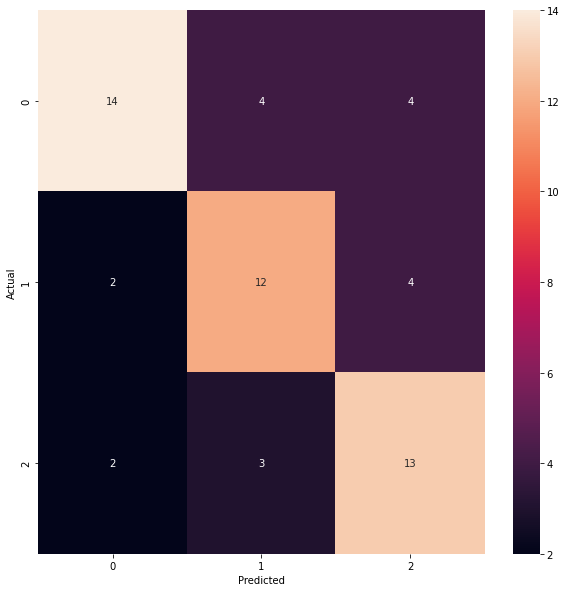

In [ ]:
f_df = df2.groupby('class').filter(lambda x : len(x) > 32)
encoder = LabelEncoder()
encoded_values = encoder.fit_transform(f_df["class"].values)
f_df["class_id"] = pd.Series(encoded_values, index=f_df.index)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
features = f_df[f_df.columns[:6]].values
labels = f_df['class_id'].values


model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, f_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.datasets import make_multilabel_classification

# this will generate a random multi-label dataset
X, y = make_multilabel_classification(sparse = True, n_labels = 5,return_indicator = 'sparse', allow_unlabeled = True)

In [ ]:
y

<100x5 sparse matrix of type '<class 'numpy.int64'>'
	with 363 stored elements in Compressed Sparse Row format>

In [ ]:
for n in range(2,9):
  target = "class-{}".format(n)
  temp = df[["Labels", "Question_lemma", "Question_focus",	"Question_concepts",	"Dependency_pairs",	"Head_dependency_pairs",target]].dropna()
  temp.rename(columns={target: "Class"}, inplace=True)
  tdf = pd.concat([tdf, temp], ignore_index=True, sort=False)

tdf.info()

In [ ]:
df.apply(lambda x: some_func(a = x['a'], b = x['b'], c = x['c']), axis=1)

In [ ]:
matching = [s for s in semantic_types if focus in s]


['transporter (Membrane Transport Proteins) [aapp,bacs]',
 'transporter (Membrane Transport Proteins) [aapp,bacs]']

In [ ]:
# def get_concept(question):
#   try:
#     doc = nlp(question)
#     # print("entites:{}".format(doc.ents))
#     focus = focus_extraction(question)
#     # print("focus:{}".format(focus))
#     for ent in doc.ents:
#       # print("focus:{} - ent:{}".format(focus,ent.lemma_))
#       if focus != None and focus.lemma_ in ent.lemma_:
#         # concept = str(ent.lemma_)
#         concept = ent
#         # print("concept: {}".format(concept))
#         return concept
#   except:
#     return None    


In [ ]:
df['Question_concepts'] = df['Question'].swifter.apply(lambda row : get_concept(row))

Pandas Apply:   0%|          | 0/773 [00:00<?, ?it/s]

In [ ]:
df[['Question','Question_concepts']].to_csv("Qs&concept.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773 entries, 0 to 780
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Question           773 non-null    object
 1   Documents          689 non-null    object
 2   Ideal_Answer       696 non-null    object
 3   Exact_Answer       689 non-null    object
 4   Concept            552 non-null    object
 5   Labels             773 non-null    object
 6   class-1            773 non-null    object
 7   class-2            359 non-null    object
 8   class-3            119 non-null    object
 9   class-4            31 non-null     object
 10  class-5            13 non-null     object
 11  class-6            5 non-null      object
 12  class-7            2 non-null      object
 13  class-8            2 non-null      object
 14  Question_lemma     773 non-null    object
 15  Question_focus     726 non-null    object
 16  Question_concepts  629 non-null    object
dt

In [ ]:
type(df['Question_concepts' ][0])

NoneType

In [ ]:
df['Question_concepts' ].isna().sum()

144

In [ ]:
df[df['Question_concepts'].isna()]

In [ ]:
concept = get_concept("list signaling molecules (ligands) that interact with the receptor EGFR")
print(concept)

entites:(list, signaling molecules, ligands, interact, receptor EGFR)
focus:list
concept: list
list


# Semantic dependency parsing

In [ ]:
from itertools import combinations
from itertools import product

In [ ]:
# -----------------backup-----------------
def get_dependency_pairs(question):
  try:
    doc = nlp(question)
    concept = get_concept(question)
    dependency_pairs = []
    for word in concept:
      dependency_pairs.append([(child,word) for child in word.children])
    dependency_pairs = max(dependency_pairs,key=len)
    if dependency_pairs:
      # print(dependency_pairs)
      return dependency_pairs
    else:
      # print([(concept,)])
      return (concept,)
  except:
    return None

In [ ]:
def get_dependency_pairs(question):
  try:
    doc = nlp(question)
    concept = get_concept(question)
    dependency_pairs = []
    for word in concept:
      dependency_pairs.append([child.lemma_+' '+word.lemma_ for child in word.children])
    dependency_pairs = max(dependency_pairs,key=len)
    if dependency_pairs:
      dependency_pair_string = ' '.join([pair for pair in dependency_pairs])
      # print("dep pair string:{}".format(dependency_pair_string))
      return dependency_pair_string
    else:
      # print("returning concept as dep pairs:{}".format(concept.lemma_))
      return concept.lemma_
  except:
    # print("None")
    return None

In [ ]:
df['Dependency_pairs'] = df['Question'].swifter.apply(lambda row : get_dependency_pairs(row))

Pandas Apply:   0%|          | 0/773 [00:00<?, ?it/s]

In [ ]:
df['Dependency_pairs'].isnull().sum()

In [ ]:
df[['Question','Dependency_pairs']].to_csv("Qs&dprs.csv")

In [ ]:
df[df["Dependency_pairs"].astype(bool) == False]

In [ ]:
df[df['Dependency_pairs'].isna()]

In [ ]:
question = "Abnormalities in which chromosomes were linked to the Moyamoya disease?"
get_dependency_pairs(question)
get_head_dependency_pairs(question)

'abnormality link chromosome link be link disease link ? link'

# Semantic head dependency

In [ ]:
# -----------------backup-----------------
def get_head_dependency_pairs(question):
  doc = nlp(question)
  try:
    focus,concept = get_concept(question)
    head_dependency_pairs = []
    for word in concept:
      print( "word: {}->{}".format( word,word.head) )
      head_dependency_pairs.append([(child,word.head) for child in word.head.children])
    head_dependency_pairs = max(head_dependency_pairs,key=len)
    if head_dependency_pairs:
      # print(head_dependency_pairs)
      return head_dependency_pairs
  except:
    # print("None")
    return None

In [ ]:
def get_head_dependency_pairs(question):
  try:
    doc = nlp(question)
    concept = get_concept(question)
    dependency_pairs = []
    for word in concept:
      dependency_pairs.append([child.lemma_+' '+word.head.lemma_ for child in word.head.children])
    dependency_pairs = max(dependency_pairs,key=len)
    if dependency_pairs:
      dependency_pair_string = ' '.join([pair for pair in dependency_pairs])
      # print("head_dep pair string:{}".format(dependency_pair_string))
      # return dependency_pair_string
      return dependency_pairs
  except:
    # print("None")
    return None

In [ ]:
question = "Abnormalities in which chromosomes were linked to the Moyamoya disease?"
get_head_dependency_pairs(question)

['abnormality link', 'chromosome link', 'be link', 'disease link', '? link']

In [ ]:
df['Head_dependency_pairs'] = df['Question'].swifter.apply(lambda row : get_head_dependency_pairs(row))

Pandas Apply:   0%|          | 0/773 [00:00<?, ?it/s]

In [ ]:
df[['Question','Head_dependency_pairs']].to_csv("Qs&Headprs.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773 entries, 0 to 780
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Question               773 non-null    object
 1   Documents              689 non-null    object
 2   Ideal_Answer           696 non-null    object
 3   Exact_Answer           689 non-null    object
 4   Concept                552 non-null    object
 5   Labels                 773 non-null    object
 6   class-1                773 non-null    object
 7   class-2                359 non-null    object
 8   class-3                119 non-null    object
 9   class-4                31 non-null     object
 10  class-5                13 non-null     object
 11  class-6                5 non-null      object
 12  class-7                2 non-null      object
 13  class-8                2 non-null      object
 14  Question_lemma         773 non-null    object
 15  Question_pos_tag       

In [ ]:
df[df["Dependency_pairs"].isna()]

In [ ]:
df.to_csv("whole_dataset_b4_trans.csv")

#Data investigation

In [ ]:
feature_name = 'Head_dependency_pairs'
for idx, value in enumerate(df[feature_name]):
  print("Question lemma:{}".format(df['Question_lemma'].iloc[idx]))
  print(value)

# Classification 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_val_predict
# from sklearn.base import TransformerMixin
# from sklearn.pipeline import Pipeline
from functools import partial
from itertools import repeat
from multiprocessing import Pool, freeze_support
from itertools import product
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
import traceback
import sys

##Data-set formation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773 entries, 0 to 780
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Question      773 non-null    object
 1   Documents     689 non-null    object
 2   Ideal_Answer  696 non-null    object
 3   Exact_Answer  689 non-null    object
 4   Concept       552 non-null    object
 5   Labels        773 non-null    object
 6   class-1       773 non-null    object
 7   class-2       359 non-null    object
 8   class-3       119 non-null    object
 9   class-4       31 non-null     object
 10  class-5       13 non-null     object
 11  class-6       5 non-null      object
 12  class-7       2 non-null      object
 13  class-8       2 non-null      object
dtypes: object(14)
memory usage: 90.6+ KB


In [ ]:
tdf = df[["Labels", "Is_choice","Is_quantity","Question_lemma", "Question_focus",	"Question_concepts",	"Dependency_pairs",	"Head_dependency_pairs","class-1"]].dropna()
tdf.rename(columns={"class-1": "Class"}, inplace=True)
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 780
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Labels                 629 non-null    object
 1   Is_choice              629 non-null    int64 
 2   Is_quantity            629 non-null    int64 
 3   Question_lemma         629 non-null    object
 4   Question_focus         629 non-null    object
 5   Question_concepts      629 non-null    object
 6   Dependency_pairs       629 non-null    object
 7   Head_dependency_pairs  629 non-null    object
 8   Class                  629 non-null    object
dtypes: int64(2), object(7)
memory usage: 49.1+ KB


In [ ]:
#Copy Transformation
for n in range(2,9):
  target = "class-{}".format(n)
  temp = df[["Labels", "Question_lemma", "Question_focus",	"Question_concepts",	"Dependency_pairs",	"Head_dependency_pairs",target]].dropna()
  temp.rename(columns={target: "Class"}, inplace=True)
  tdf = pd.concat([tdf, temp], ignore_index=True, sort=False)

tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Labels                 1075 non-null   object 
 1   Is_choice              629 non-null    float64
 2   Is_quantity            629 non-null    float64
 3   Question_lemma         1075 non-null   object 
 4   Question_focus         1075 non-null   object 
 5   Question_concepts      1075 non-null   object 
 6   Dependency_pairs       1075 non-null   object 
 7   Head_dependency_pairs  1075 non-null   object 
 8   Class                  1075 non-null   object 
dtypes: float64(2), object(7)
memory usage: 75.7+ KB


##Backup and restore

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#copy to drive
# tdf.to_csv("prepared_data.csv")
%cp  "/content/prepared_data.csv" "/content/drive/MyDrive/multi_label_question_classification/"
# %cp  "/content/cv_df_ngram_0-2.csv" "/content/drive/MyDrive/multi_label_question_classification/"


cp: cannot stat '/content/prepared_data.csv': No such file or directory


In [ ]:
#drive to colab
%cp "/content/drive/MyDrive/multi_label_question_classification/prepared_data.csv" "/content/"
# %cp "/content/drive/MyDrive/multi_label_question_classification/cv_df_ngram_0-2.csv" "/content/"


In [ ]:
tdf = pd.read_csv("prepared_data.csv")
tdf = tdf.loc[:, ~tdf.columns.str.contains('^Unnamed')]
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Labels                 1075 non-null   object 
 1   Is_choice              629 non-null    float64
 2   Is_quantity            629 non-null    float64
 3   Question_lemma         1075 non-null   object 
 4   Question_focus         1075 non-null   object 
 5   Question_concepts      1075 non-null   object 
 6   Dependency_pairs       1075 non-null   object 
 7   Head_dependency_pairs  1075 non-null   object 
 8   Class                  1075 non-null   object 
dtypes: float64(2), object(7)
memory usage: 75.7+ KB


In [ ]:
tdf['Labels'].value_counts()

##Combine columns

In [ ]:
#
tdf['Combined'] = tdf[tdf.columns[:-2]].apply(
    lambda x: ' '.join(x.astype(str)),
    axis=1
)

In [ ]:
tdf["Combined"][0]

'factoid which thyroid hormone transporter be implicate in thyroid hormone resistance syndrome ? transporter thyroid hormone transporter which transporter thyroid transporter hormone transporter transporter implicate be implicate syndrome implicate ? implicate'

In [ ]:
tdf["Combined"].str.len().min()

42

In [ ]:
data_n_class = []
for n in range(1,51):
  n_class = tdf.groupby('Class').filter(lambda x : len(x) > n)['Class'].nunique()
  data_n_class.append((n,n_class))

data_n_class

[(1, 59),
 (2, 49),
 (3, 45),
 (4, 41),
 (5, 35),
 (6, 31),
 (7, 28),
 (8, 27),
 (9, 27),
 (10, 27),
 (11, 21),
 (12, 18),
 (13, 16),
 (14, 14),
 (15, 13),
 (16, 13),
 (17, 13),
 (18, 13),
 (19, 13),
 (20, 12),
 (21, 12),
 (22, 12),
 (23, 11),
 (24, 11),
 (25, 11),
 (26, 9),
 (27, 9),
 (28, 9),
 (29, 7),
 (30, 7),
 (31, 7),
 (32, 7),
 (33, 6),
 (34, 6),
 (35, 6),
 (36, 6),
 (37, 6),
 (38, 6),
 (39, 6),
 (40, 6),
 (41, 6),
 (42, 6),
 (43, 6),
 (44, 6),
 (45, 6),
 (46, 6),
 (47, 6),
 (48, 6),
 (49, 5),
 (50, 5)]

In [ ]:
pd.get_dummies(data = tdf ,columns=['Class'])

In [ ]:
def find_best_parameters(n_data,n_gram,mndf):
  try:
    f_df = tdf.groupby('Class').filter(lambda x : len(x) > n_data)

    encoder = LabelEncoder()
    encoded_values = encoder.fit_transform(f_df["Class"].values)
    f_df["Class_id"] = pd.Series(encoded_values, index=f_df.index)
    
    models = [LogisticRegression(multi_class='multinomial',random_state=0)]

    tfidf = TfidfVectorizer( norm='l2', sublinear_tf=True, min_df=mndf, ngram_range=(1,n_gram))
    sample = f_df[[ 'Labels',	'Question_lemma',	'Question_focus',	'Question_concepts',	'Dependency_pairs',	'Head_dependency_pairs'	]]
    features = sp.hstack(sample.apply(lambda col: tfidf.fit_transform(col)))
    # features = tfidf.fit_transform(f_df.Combined).toarray()
    labels = f_df.Class_id
    entries = []
    for model in models:
            model_name = model.__class__.__name__
            accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10, n_jobs= 10)
            for fold_idx, accuracy in enumerate(accuracies):
                entries.append((model_name,n_data, n_gram, mndf, fold_idx, accuracy))
                # entries.append((n_data, n_gram, mndf, fold_idx, accuracy))
    return entries
  
  except Exception:
    print(traceback.format_exc())
    print(" exception for n_gram: {} and min_df:{}".format(n_gram, mndf))


In [ ]:
n_data_list = [1,2,3,4,5,7,10]
n_gram_list = [*range(1,4)] # last range 3
mndf_list =  [*range(6,21)]
param_list = list(product(n_data_list,n_gram_list, mndf_list))
len(param_list)

315

In [ ]:
if __name__ == '__main__':
    freeze_support()
    with Pool(processes=16) as pool:
        results = pool.starmap(find_best_parameters,param_list)
# results

In [ ]:
cv_list = [tpl for result in  results for tpl in result if result != None]
cv_df = pd.DataFrame(cv_list, columns=['model_name','n_data','n_gram','min_df', 'fold_idx', 'accuracy'])

In [ ]:
# cv_df = pd.read_csv("cv_df_ngram_0-2.csv")
# old_cv_df = pd.read_csv("cv_df_ngram_0-2.csv")

In [ ]:
cv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   model_name  3150 non-null   object 
 1   n_data      3150 non-null   int64  
 2   n_gram      3150 non-null   int64  
 3   min_df      3150 non-null   int64  
 4   fold_idx    3150 non-null   int64  
 5   accuracy    3150 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 147.8+ KB


In [ ]:
cv_df[cv_df["accuracy"] == cv_df["accuracy"].max()]

,model_name,n_data,n_gram,min_df,fold_idx,accuracy
3120,LogisticRegression,10,3,18,0,0.380435


In [ ]:
max_10 =cv_df[cv_df["n_data"] == 10]['accuracy'].max()
cv_df[cv_df["accuracy"] == max_10]


,model_name,n_data,n_gram,min_df,fold_idx,accuracy
3120,LogisticRegression,10,3,18,0,0.380435


In [ ]:
max_10 =cv_df[cv_df["n_data"] == 10]['accuracy'].max()
cv_df[cv_df["accuracy"] == max_10]


,model_name,n_data,n_gram,min_df,fold_idx,accuracy
3120,LogisticRegression,10,3,18,0,0.380435


In [ ]:
file_name = "cv_df_ngram_1-3_mindf_6-20_with_all_col_feat.csv"
cv_df.to_csv(file_name)
%cp   $file_name "/content/drive/MyDrive/multi_label_question_classification/"


##Testing

In [ ]:
# target_feature = 'Most Active Current News Type'
#use encoder and transform
encoder = LabelEncoder()
encoded_values = encoder.fit_transform(tdf["Class"].values)
tdf["Class_id"] = pd.Series(encoded_values, index=tdf.index)

In [ ]:

sample = tdf[[ 'Labels',	'Question_lemma',	'Question_focus',	'Question_concepts',	'Dependency_pairs',	'Head_dependency_pairs'	]]
sample = sample.apply(lambda col: col.str.strip())
# for n in range(1,50):
vect = CountVectorizer(ngram_range=(1,27))
train = sp.hstack(sample.apply(lambda col: vect.fit_transform(col)))
print(train.shape,n)

(1073, 53475) 49


In [ ]:
for n_gram in range(1,50):
  tfidf = TfidfVectorizer( norm='l2', sublinear_tf=True, min_df=mndf, ngram_range=(n_gram,n_gram))
  features = tfidf.fit_transform(tdf.Question_lemma).toarray()
  print(features.shape)

In [ ]:
def check_feature_shape(n_data,n_gram,mndf):
  try:
    f_df = tdf.groupby('Class').filter(lambda x : len(x) > n_data)

    encoder = LabelEncoder()
    encoded_values = encoder.fit_transform(f_df["Class"].values)
    f_df["Class_id"] = pd.Series(encoded_values, index=f_df.index)
    

    tfidf = TfidfVectorizer( norm='l2', sublinear_tf=True, min_df=mndf, ngram_range=(1,n_gram))
    combined_col_features = tfidf.fit_transform(f_df.Combined).toarray()
    
    sample = f_df[[ 'Labels',	'Question_lemma',	'Question_focus',	'Question_concepts',	'Dependency_pairs',	'Head_dependency_pairs'	]]
    all_col_features = sp.hstack(sample.apply(lambda col: tfidf.fit_transform(col)))

    labels = f_df.Class_id

    entries = [ n_data , n_gram, mndf, all_col_features.shape[1],combined_col_features.shape[1], labels.shape]
    return entries
  
  except Exception:
    print(traceback.format_exc())
    print(" exception for n_gram: {} and min_df:{}".format(n_gram, mndf))


In [ ]:
check_feature_shape(1,2,3)

[1, 2, 3, 3517, 2112, (1050,)]

In [ ]:
n_data_list = [0,1]
n_gram_list = [*range(35,50)] # last range 3
mndf_list =  [*range(1,5)]
param_list = list(product(n_data_list,n_gram_list,mndf_list))
len(param_list)

120

In [ ]:
if __name__ == '__main__':
    freeze_support()
    with Pool(processes=4) as pool:
        results = pool.starmap(check_feature_shape,param_list)

In [ ]:
tfidf_df = pd.DataFrame(results, columns = [ 'n_data' , 'n_gram', 'mndf', 'all_col_features','combined_col_features', 'labels'])
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   n_data                 120 non-null    int64 
 1   n_gram                 120 non-null    int64 
 2   mndf                   120 non-null    int64 
 3   all_col_features       120 non-null    int64 
 4   combined_col_features  120 non-null    int64 
 5   labels                 120 non-null    object
dtypes: int64(5), object(1)
memory usage: 5.8+ KB


In [ ]:
tfidf_df.sort_values('combined_col_features',ascending=False).head(15)

,n_data,n_gram,mndf,all_col_features,combined_col_features,labels
28,0,42,1,53475,95450,"(1073,)"
32,0,43,1,53475,95450,"(1073,)"
36,0,44,1,53475,95450,"(1073,)"
40,0,45,1,53475,95450,"(1073,)"
44,0,46,1,53475,95450,"(1073,)"
48,0,47,1,53475,95450,"(1073,)"
52,0,48,1,53475,95450,"(1073,)"
56,0,49,1,53475,95450,"(1073,)"
24,0,41,1,53475,95449,"(1073,)"
20,0,40,1,53475,95447,"(1073,)"


In [ ]:
mndf = 5
n_gram = 27
# best_accuracy = 0

# tdf = tdf.groupby('Class').filter(lambda x : len(x) > 10)
# print(tdf['Class'].nunique())
encoder = LabelEncoder()
encoded_values = encoder.fit_transform(tdf["Class"].values)
tdf["Class_id"] = pd.Series(encoded_values, index=tdf.index)

sample = tdf[[ 'Labels',	'Question_lemma',	'Question_focus',	'Question_concepts',	'Dependency_pairs',	'Head_dependency_pairs'	]]

tfidf = TfidfVectorizer( norm='l2', sublinear_tf=True, min_df=mndf, ngram_range=(1,n_gram))

features = sp.hstack(sample.apply(lambda col: tfidf.fit_transform(col)))

# features = tfidf.fit_transform(tdf.Combined).toarray()
# features = preprocessing.normalize(train, norm='l2')
labels = tdf.Class_id

# X_train, X_test, y_train, y_test = train_test_split(tdf['Combined'], tdf['Class'], random_state = 0)
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# clf = MultinomialNB().fit(X_train_tfidf, y_train)

models = [LogisticRegression(multi_class='multinomial',random_state=0)]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV,n_jobs=100)
    for fold_idx, accuracy in enumerate(accuracies):
        # entries.append((model_name, n_gram, mndf, fold_idx, accuracy))
        entries.append((model_name, fold_idx, accuracy))

        # if accuracy > best_accuracy:
        #   best_accuracy = accuracy
        #   best_model = model

# cv_df = pd.DataFrame(entries, columns=['model_name','n_gram','min_df', 'fold_idx', 'accuracy'])
cv_df = pd.DataFrame(entries, columns=['model_name','fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
cv_df[cv_df["accuracy"] == cv_df["accuracy"].max()]

,model_name,fold_idx,accuracy
1,LogisticRegression,1,0.314815


In [ ]:
print(cv_df.groupby('model_name').accuracy.mean())

model_name
LogisticRegression    0.205815
Name: accuracy, dtype: float64


In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, tdf.index, test_size=0.3, random_state=0)
# best_model.fit(X_train, y_train)
# Make cross validated predictions
predictions = cross_val_predict(best_model, features, labels, cv=CV)
# plt.scatter(y_test, predictions)

In [ ]:
print(metrics.classification_report(labels, predictions,target_names=tdf['Class'].unique()))

In [ ]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

tfidf_vector = TfidfVectorizer(sublinear_tf=True, norm='l2', ngram_range=(10,10))
bow_vector = CountVectorizer( ngram_range=(10,10))
X = tdf['Question_lemma'] # the features we want to analyze
ylabels = tdf['target_class'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

# classifier = LogisticRegression()
classifier = LogisticRegression(multi_class='ovr', solver='liblinear')

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
# print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
# print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.09523809523809523


# Deep Learning

##Requred modules and data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_val_predict
from multiprocessing import Pool, freeze_support
from itertools import product
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
import traceback
import sys

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
%cp "/content/drive/MyDrive/multi_label_question_classification/prepared_data.csv" "/content/"

In [ ]:
tdf = pd.read_csv("prepared_data.csv")
tdf = tdf.loc[:, ~tdf.columns.str.contains('^Unnamed')]
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073 entries, 0 to 1072
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Labels                 1073 non-null   object
 1   Question_lemma         1073 non-null   object
 2   Question_focus         1073 non-null   object
 3   Question_concepts      1073 non-null   object
 4   Dependency_pairs       1073 non-null   object
 5   Head_dependency_pairs  1073 non-null   object
 6   Class                  1073 non-null   object
dtypes: object(7)
memory usage: 58.8+ KB


In [ ]:
# To get combined feature
tdf['Combined'] = tdf[tdf.columns[:-2]].apply(
    lambda x: ' '.join(x.astype(str)),
    axis=1
)

In [ ]:
tdf["Combined"].head()

0    factoid which thyroid hormone transporter be i...
1    list which mirna could be use as potential bio...
2    list which acetylcholinesterase inhibitor be u...
3    list which be the class of anti-arrhythmic dru...
4    list which be the different isoform of the mam...
Name: Combined, dtype: object

In [ ]:
encoder = LabelEncoder()
encoded_values = encoder.fit_transform(tdf["Class"].values)
tdf["Class_id"] = pd.Series(encoded_values, index=tdf.index)

In [ ]:
# tdf = tdf.groupby('Class').filter(lambda x : len(x) > 2)

In [ ]:
# tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 0 to 1071
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Labels                 1030 non-null   object
 1   Question_lemma         1030 non-null   object
 2   Question_focus         1030 non-null   object
 3   Question_concepts      1030 non-null   object
 4   Dependency_pairs       1030 non-null   object
 5   Head_dependency_pairs  1030 non-null   object
 6   Class                  1030 non-null   object
 7   Combined               1030 non-null   object
 8   Class_id               1030 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 80.5+ KB


##LR with RBM

In [ ]:
mndf = 1
n_gram = 2
# best_accuracy = 0

# tdf = tdf.groupby('Class').filter(lambda x : len(x) > 10)
# print(tdf['Class'].nunique())

tfidf = TfidfVectorizer( norm='l2', sublinear_tf=True, min_df=mndf, ngram_range=(1,n_gram))
# sample = tdf[[ 'Labels',	'Question_lemma',	'Question_focus',	'Question_concepts',	'Dependency_pairs',	'Head_dependency_pairs'	]]
# features = sp.hstack(sample.apply(lambda col: tfidf.fit_transform(col))).toarray()
features = tfidf.fit_transform(tdf.Combined).toarray()
labels = tdf.Class_id


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

In [ ]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                70370     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 70,381
Trainable params: 70,381
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    batch_size=10)
from keras.backend import clear_session
clear_session()
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##One Hot encoding

In [ ]:
labels.shape

(1073,)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# encoder = LabelEncoder()
# encoded_values = encoder.fit_transform(tdf["Class"].values)
encoder = OneHotEncoder(sparse=False)
city_labels = encoded_values.reshape((labels.shape[0], 1))
encoder.fit_transform(city_labels)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##Word Embeddings

In [ ]:
sentences_train, sentences_test, y_train, y_test= train_test_split(tdf.Combined.values, tdf.Class_id.values, test_size=0.2, random_state=0)

In [ ]:
from keras.preprocessing.text import Tokenizer
# tokenizer = Tokenizer(num_words=5000)
tokenizer = Tokenizer()
# tokenizer.fit_on_texts(sentences_train)
tokenizer.fit_on_texts(tdf.Combined.values)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(sentences_train[2])
print(X_train[2])

list what be be measure with an accelerometer in back pain patient accelerometer accelerometer with accelerometer an accelerometer
[4, 10, 2, 2, 201, 29, 127, 498, 8, 1348, 746, 75, 498, 498, 29, 498, 127, 498]


In [ ]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[0, :])

[   4    1   53  109    2   81   17    2 1351  190  168  924   53  924
    1  109   53  109    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           85000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 135,021
Trainable params: 135,021
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
14/14 [==============================] - 1s 19ms/step - loss: -55.0674 - accuracy: 0.0105 - val_loss: -163.1759 - val_accuracy: 0.0047
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: -312.9601 - accuracy: 0.0117 - val_loss: -551.4984 - val_accuracy: 0.0047
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: -851.4775 - accuracy: 0.0117 - val_loss: -1281.8912 - val_accuracy: 0.0047
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: -1798.6432 - accuracy: 0.0117 - val_loss: -2488.7256 - val_accuracy: 0.0047
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: -3281.8704 - accuracy: 0.0117 - val_loss: -4315.3789 - val_accuracy: 0.0047
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: -5460.6948 - accuracy: 0.0117 - val_loss: -6900.2661 - val_accuracy: 0.0047
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: -8445.8652 - accuracy: 0.0117 - val_lo

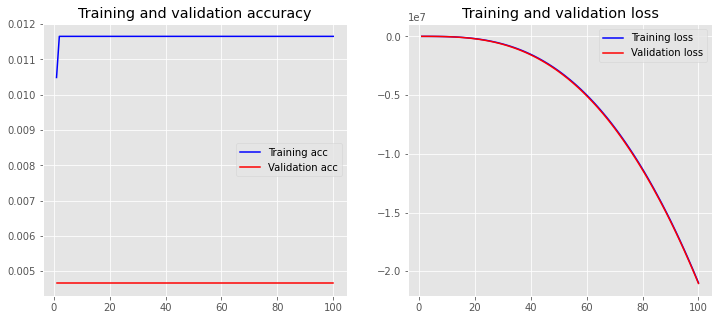

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           85000     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 85,521
Trainable params: 85,521
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.0117
Testing Accuracy:  0.0047


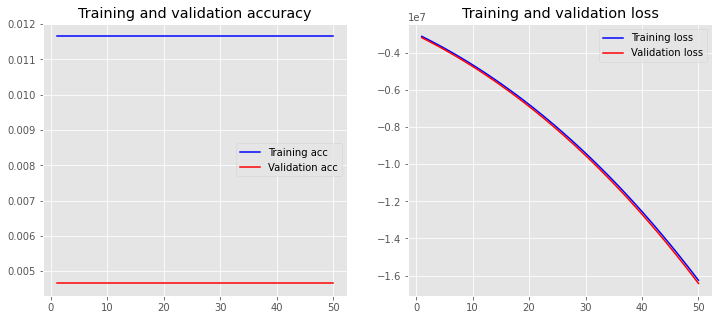

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##Glove

In [ ]:
# !wget "https://nlp.stanford.edu/data/glove.6B.zip"

In [ ]:
# !unzip glove*.zip

In [ ]:
# %cp -r *.txt /content/drive/MyDrive/multi_label_question_classification/glove/
%cp -r /content/drive/MyDrive/multi_label_question_classification/glove/*.txt /content

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.300d.txt',tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8423529411764706

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           85000     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 85,521
Trainable params: 85,521
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.0117
Testing Accuracy:  0.0047


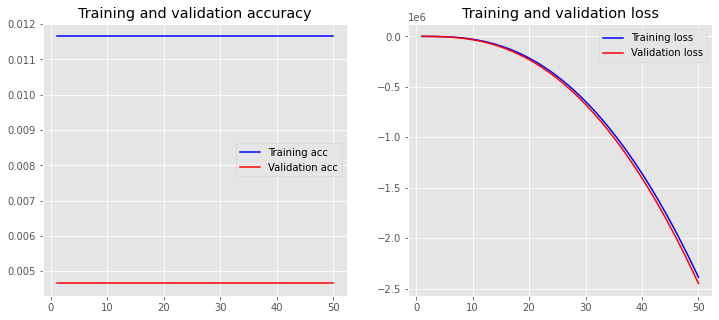

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##CNN

In [ ]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          170000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 235,429
Trainable params: 235,429
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.0117
Testing Accuracy:  0.0047


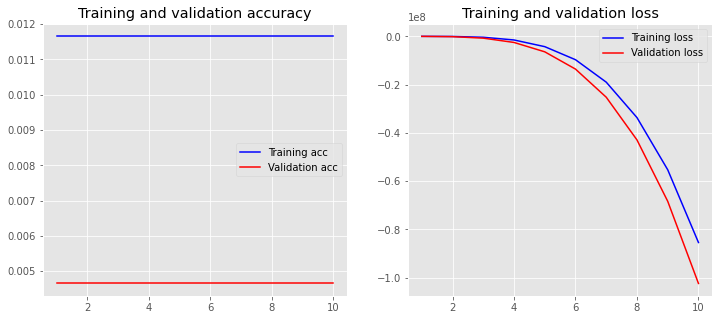

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

##Hyperparameters Optimization

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

# BioAsk

### Install cudf

In [1]:
!python --version
!lsb_release -a
!nvcc -V && which nvcc
!nvidia-smi

Python 3.7.13
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
/usr/local/cuda/bin/nvcc
Thu May 12 04:40:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.

In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.

!git clone https://github.com/rapidsai-community/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 300 (delta 74), reused 99 (delta 55), pack-reused 171
Receiving objects: 100% (300/300), 87.58 KiB | 6.74 MiB/s, done.
Resolving deltas: 100% (136/136), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [742 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.2 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-ba

In [2]:
## Installing CondaColab.  This will restart your kernel again
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:25
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL, 
!python rapidsai-csp-utils/colab/install_rapids.py stable core
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.15.0
Uninstalling cffi-1.15.0:
  Successfully uninstalled cffi-1.15.0
  Using cached cffi-1.15.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (427 kB)
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.


In [ ]:
# or, for CUDA 11.2
!conda install -c rapidsai -c nvidia -c numba -c conda-forge \
    cudf=21.08 python=3.7 cudatoolkit=11.2

In [ ]:
# Critical imports
import cudf
import cuml
import os
import numpy as np
import pandas as pd

In [4]:
!pip install cudf

  ERROR: Failed building wheel for cudf
  Running setup.py clean for cudf
Failed to build cudf
    Running setup.py install for cudf ... error
ERROR: Command errored out with exit status 1: /usr/local/bin/python3.7 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-myju4ko1/cudf_758a37a166774cc49f784bd2f275fc96/setup.py'"'"'; __file__='"'"'/tmp/pip-install-myju4ko1/cudf_758a37a166774cc49f784bd2f275fc96/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-2l0_ahpw/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7m/cudf Check the logs for full command output.


## data investigation

In [ ]:
%cp /content/drive/MyDrive/multi_label_question_classification/BioASQ-trainingDataset4b.json /content

In [ ]:
%cp -r "/content/drive/MyDrive/multi_label_question_classification/BioASQ Data/Task4BGoldenEnriched/." "/content"

In [ ]:
df[df.ideal_answer.str.len() <= 3].index

In [ ]:
"exact_answer"

## import data

In [ ]:
import pandas as pd
%cp /content/drive/MyDrive/multi_label_question_classification/bioAsk-manual-curated-train.xlsx /content
df = pd.read_excel('bioAsk-manual-curated-train.xlsx',sheet_name=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Question       1337 non-null   object 
 1   Type           1336 non-null   object 
 2   Ideal Answer   1337 non-null   object 
 3   Exact Answer   1044 non-null   object 
 4   Focus          0 non-null      float64
 5   Quantity Type  0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 62.8+ KB


## leammetization

In [ ]:
!pip install -U spacy
!wget https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_scibert-0.4.0.tar.gz
!pip install en_core_sci_scibert-0.4.0.tar.gz
!pip install scispacy
!pip install swifter

In [14]:
import spacy
import scispacy
import swifter
nlp = spacy.load("en_core_sci_scibert")

/usr/local/lib/python3.7/dist-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_sci_scibert' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
def get_lemma(question):
    try:
      doc = nlp(str(question))
      lemmetized = ' '.join([n.lemma_ for n in doc])
      return lemmetized
    except:
      return None

In [7]:
df['question_lemma'] = df['Question'].map(lambda row : get_lemma(row))

In [8]:
df

,Question,Type,Ideal Answer,question_lemma
0,What symptoms characterize the Muenke syndrome?,summary,Muenke syndrome is characterized by considerab...,what symptom characterize the Muenke syndrome ?
1,What is the inheritance pattern of Li-Fraumeni...,factoid,Li-Fraumeni syndrome shows autosomal dominant ...,what be the inheritance pattern of li-fraumeni...
2,What are the indications for alteplase?,List,Intravenous alteplase (recombinant tissue plas...,what be the indication for alteplase ?
3,What is the role of Inn1 in cytokinesis?,summary,Inn1 associates with the contractile actomyosi...,what be the role of inn1 in cytokinesis ?
4,What is the main role of Ctf4 in dna replication?,factoid,Ctf4 coordinates the progression of helicase a...,what be the main role of ctf4 in dna replicati...
...,...,...,...,...
1318,Which is the receptor for substrates of Chaper...,factoid,Chaperone-mediated autophagy (CMA) is a lysoso...,which be the receptor for substrate of chapero...
1319,Which are the Atg8 homologs in human?,List,Autophagy (Autophagy-related protein 8 or Atg8...,which be the atg8 homolog in human ?
1320,Describe the known functions for the prothymos...,summary,Prothymosin alpha (ProTα) (encoded in human by...,describe the known function for the prothymosi...
1321,Has field-programmable gate array (FPGA) techn...,yesno,Yes. Field-Programmable Gate Arrays (FPGAs) ar...,have field-programmable gate array ( fpga ) te...


## Clean data

### clean type columns

In [ ]:
for column in df.columns:
  print(column)
  print(df[column].value_counts())
  print("-----------------------")

In [ ]:
df['Type'].value_counts()

In [ ]:
df['id'].value_counts()[:15]

1273

In [ ]:
def clean_qtypes(types):
  if types in ['summary','yesno','list','factoid']:
    return types
  else:
    return None

In [ ]:
df['type'] = df['type'].apply(clean_qtypes)
print(df['type'].value_counts())
print(df['type'].value_counts().sum())
print(df['type'].isna().sum())

summary    217
yesno       56
list        55
factoid     43
Name: type, dtype: int64
371
936


In [ ]:
df['id'] = df['id'].apply(clean_qtypes)
print(df['id'].value_counts())
print(df['id'].value_counts().sum())
print(df['id'].isna().sum())

yesno      299
factoid    271
list       246
Name: id, dtype: int64
816
491


In [ ]:
df['type'].fillna(df['id'],inplace=True)

### Clean null value

In [ ]:
df[['Question','Type','Ideal Answer']].isna().sum()

Question        0
Type            0
Ideal Answer    0
dtype: int64

In [ ]:
pd.reset_option("max_colwidth")
pd.get_option("max_colwidth")

50

In [ ]:
# pd.set_option("max_colwidth", 100)
df['Type'][df[df['Type'].isna()].index] = 'yesno'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df = df[['Question','Type','Ideal Answer']]
df.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df.isna().sum()

Question        0
Type            0
Ideal Answer    0
dtype: int64

In [ ]:
# df.to_csv('BioASQ-train4b-3features.csv')
file_name = 'bioAsk-manual-curated-train-3features.csv'
df.to_csv(file_name)

In [ ]:
%cp /content/$file_name /content/drive/MyDrive/multi_label_question_classification

### clean up question column

In [ ]:
import pandas as pd
file_name = 'bioAsk-manual-curated-train-3features.csv'
%cp /content/drive/MyDrive/multi_label_question_classification/$file_name /content
df = pd.read_csv(file_name)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Question      1336 non-null   object
 1   Type          1336 non-null   object
 2   Ideal Answer  1336 non-null   object
dtypes: object(3)
memory usage: 31.4+ KB


In [ ]:
# df["body"] = df["body"].str.lower()

In [ ]:
from collections import Counter
col_name = 'Question'
char_list = []
# for idx, question in enumerate(df["body"]):
#   print(idx,[c for c in question if not c.isalnum()])
for item in df[col_name]:
  for c in item:
    if not c.isalnum():
      char_list.append(c)

Counter(char_list)

Counter({' ': 11963,
         "'": 28,
         '(': 169,
         ')': 169,
         '*': 2,
         '+': 1,
         ',': 16,
         '-': 301,
         '.': 90,
         '/': 20,
         ':': 2,
         '?': 1233,
         '[': 1,
         ']': 1})

In [ ]:
col_name = 'Question'
ch2fx = '\\n'
for idx, item in enumerate(df[col_name]):
  if ch2fx in item:
    print(idx, item)
    # print(item.replace(ch2fx,'-'))
    # df[col_name].iloc[idx] = item.replace(ch2fx,'-')

In [ ]:
file_name = 'bioAsk-manual-curated-train-3features.csv'
df.to_csv(file_name)
%cp /content/$file_name /content/drive/MyDrive/multi_label_question_classification

### clean up answer column ( non alpha-nemeric char)

In [ ]:
#special item (keeping it for later)
special_idx_list = [144,834,976]
duplicates = [(1126,1152),()]

#find unicode (code) in dataframe
df['Ideal Answer'].str.extractall(r'(\\u.{4})')

#regex logics (keeping it for later)
re.findall("'.*'",item)
re.findall("\d'",item)
re.findall("'s",item)
re.findall("s'",item)
print("[{}]".format(idx),re.sub("(.{130})", "\\1\n", item, 0, re.DOTALL))#prints upto given no. of chars per line

In [ ]:
#check balanced parentheses
def matched(str):
    count = 0
    for i in str:
        if i == "(":
            count += 1
        elif i == ")":
            count -= 1
        if count < 0:
            return False
    return count == 0

In [ ]:
#find index of mismatched "()"
def find_parens(s):
    toret = {}
    pstack = []

    for i, c in enumerate(s):
        if c == '(':
            pstack.append(i)
        elif c == ')':
            if len(pstack) == 0:
                # print("No matching closing parens at: " + str(i))
                print(s[i-5:i+5])
                continue
            toret[pstack.pop()] = i

    if len(pstack) > 0:
        # print("No matching opening parens at: " + str(pstack.pop()))
        s_idx = pstack.pop()
        print(s[s_idx-5:s_idx+5])

    return toret

In [ ]:
def fix_unicode(s):
  import codecs
  unicode_index = s.find("\\u")
  #print(unicode_index)
  the_uni_code = s[unicode_index:unicode_index+6]
  the_uni_char = codecs.decode(the_uni_code, 'unicode_escape')
  # return [the_uni_code,the_uni_char]
  # return s.replace(the_uni_code,the_uni_char)

In [ ]:
#find non alpha-numeric char
from collections import Counter
col_name = 'Ideal Answer'
char_list = []

for item in df[col_name]:
  for c in item:
    if not c.isalnum():
      char_list.append(c)

Counter(char_list)

In [ ]:
exp = r'(\n\s+)'
change_to = '\n' 
df['Ideal Answer'].str.extractall(exp)

In [ ]:
#apply the fix (be careful !!!)
df['Ideal Answer'].replace(to_replace=exp, value= change_to, regex=True, inplace=True)

In [ ]:
# drop single row !
# df.drop(1152,inplace=True)

In [ ]:
#to check
import re
col_name = 'Ideal Answer'
ch2fx = '\n'
trgt_char = '\n'
for idx, item in enumerate(df[col_name]):
  # if ch2fx in item:
  if re.findall(exp,item):
  # if any(word in item for word in ch2fx):
    print(idx,item)
    # print("[{}]".format(idx),re.sub("(.{130})", "\\1\n", item, 0, re.DOTALL))
    # print("==>[{}]".format(idx),re.sub("(.{130})", "\\1\n", item.replace(ch2fx,trgt_char), 0, re.DOTALL))
    # print("==>",idx,item.replace(ch2fx,trgt_char))

In [ ]:
#apply the fix
for idx, item in enumerate(df[col_name]):
  # if ch2fx in item:
  if re.findall(exp,item):
  # if any(word in item for word in ch2fx):
    df[col_name].iloc[idx] = item.replace(ch2fx,trgt_char)

In [ ]:
#for manual fixup
s_idx = 783

# fixed_txt = "Hutchinson-Gilford progeria syndrome is a rare, sporadic, autosomal dominant syndrome that involves premature aging, generally leading to death at approximately 13 years of age due to myocardial infarction or stroke. The genetic basis of most cases of this syndrome is a change from glycine GGC to glycine GGT in codon 608 of the lamin A (LMNA) gene, which activates a cryptic splice donor site to produce abnormal lamin A; this disrupts the nuclear membrane and alters transcription."
# df['Ideal Answer'].iloc[s_idx] = fixed_txt

display(df['Question'].iloc[s_idx]d)
display(df['Ieal Answer'].iloc[s_idx])

### clean up answer column ( duplicate string )

In [ ]:
exp = r'(\.\s+\w+)'
extract_df = df['Ideal Answer'].str.extractall(exp)
extract_df

In [ ]:
extract_set = set(extract_df[0].to_list())
extract_set

In [ ]:
# find and mark matches
def mark_match(exp,s,color):
  from termcolor import colored

  splits = re.split(exp,s)
  matches= re.findall(exp,s)
  final_string = ""

  for split in splits:
    if split in matches:
      split = colored(split,color)
    final_string = final_string+split

  return final_string

In [ ]:
def clean_duplicate_string(s):
  import re
  # split and clean string based on new line
  cleaned_nl = []    
  for split_nl in s.split('\n'):
    split_nl = split_nl.strip()
    if re.findall(r',$',split_nl):
      split_nl = split_nl[:-1]
      if split_nl not in cleaned_nl:
        cleaned_nl.append(split_nl)
        cleaned_nl.append(',')
    if split_nl not in cleaned_nl:
        cleaned_nl.append(split_nl)
  cleaned_nl_joined = " ".join(cleaned_nl)

  # split and clean string based on (.) full stop
  cleaned_dot = []
  for split_dot in re.split(r'\.\s+',cleaned_nl_joined):
    split_dot = split_dot.strip('.')
    if split_dot not in cleaned_dot:
      cleaned_dot.append(split_dot)

  # clean duplicate sub-string 
  for str_x in cleaned_dot:
    for idx,str_y in enumerate(cleaned_dot):
        if str_x == str_y:
          continue
        if str_x in str_y:
          cleaned_dot[idx] = str_y.replace(str_x,"")
        

  # final cleaning and joining  
  final_set = [string for string in cleaned_dot if re.findall(r'\w+',string)]
  final_string = ". ".join(final_set)
  # display(final_set)

  return final_string

In [ ]:
# s_idx = 4
# s_idx = 176
# s_idx = 91
s_idx = 54
s = df['Ideal Answer'].iloc[s_idx]
# print(s)
print("-->",clean_duplicate_string(s))

In [ ]:
#duplicate sentence cleaning
import re
col_name = 'Ideal Answer'
for idx, item in enumerate(df[col_name]):
    print(idx,item)
    # print(idx,mark_match(exp,item,'red'))
    # print("-->",clean_duplicate_string(item))
    # print("==>[{}]".format(idx),re.sub("(.{130})", "\\1\n", clean_duplicate_string(item), 0, re.DOTALL))
    # df[col_name].iloc[idx] = clean_duplicate_string(item)

In [ ]:
file_name = 'bioAsk-manual-curated-train-3features.csv'
df.to_csv(file_name)
%cp /content/$file_name /content/drive/MyDrive/multi_label_question_classification

### fix irregular data points

In [ ]:
%cp /content/drive/MyDrive/multi_label_question_classification/BioASQ-trainingDataset4b.json /content

In [ ]:
import pandas as pd
file_name = 'bioAsk-manual-curated-train-3features.csv'
%cp /content/drive/MyDrive/multi_label_question_classification/$file_name /content
df = pd.read_csv(file_name)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.info()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
      display(df.sort_values(by="Ideal Answer", key=lambda x: x.str.len() ))
      # display(df[df['Ideal Answer'].str.len() < 4])

In [ ]:
irg_df = df[df['Ideal Answer'].str.len() < 4]
irg_df.index

In [ ]:
import json
with open("/content/BioASQ-trainingDataset4b.json") as search_file:
  json_file = json.load(search_file)

for q_id,item in enumerate(json_file['questions']):
  for question in irg_df['Question']:
    if question in item['body']:
      print(item['ideal_answer'])      

In [ ]:
df.drop(irg_df.index,inplace=True)

In [ ]:
file_name = 'bioAsk-manual-curated-train-3features.csv'
df.to_csv(file_name)
%cp /content/$file_name /content/drive/MyDrive/multi_label_question_classification

## Format type column

In [16]:
%cd /content
!pip install cudf

/content
  Using cached cudf-0.6.1.post1.tar.gz (1.1 kB)
  ERROR: Failed building wheel for cudf
  Running setup.py clean for cudf
Failed to build cudf
    Running setup.py install for cudf ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ytmra1jw/cudf_052d47a06a3f436fb2eb2f3b475108ef/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ytmra1jw/cudf_052d47a06a3f436fb2eb2f3b475108ef/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-d_pufvo1/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/cudf Check the logs for full command output.


In [15]:
import pandas as pd
import cudf
file_name = 'bioAsk-manual-curated-train-3features.csv'
%cp /content/drive/MyDrive/multi_label_question_classification/$file_name /content
df = cudf.read_csv(file_name)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.info()

ModuleNotFoundError: ignored

In [10]:
# df = pd.get_dummies(df, columns = ['Type'])
df

,Question,Type,Ideal Answer
0,What symptoms characterize the Muenke syndrome?,summary,Muenke syndrome is characterized by considerab...
1,What is the inheritance pattern of Li-Fraumeni...,factoid,Li-Fraumeni syndrome shows autosomal dominant ...
2,What are the indications for alteplase?,List,Intravenous alteplase (recombinant tissue plas...
3,What is the role of Inn1 in cytokinesis?,summary,Inn1 associates with the contractile actomyosi...
4,What is the main role of Ctf4 in dna replication?,factoid,Ctf4 coordinates the progression of helicase a...
...,...,...,...
1318,Which is the receptor for substrates of Chaper...,factoid,Chaperone-mediated autophagy (CMA) is a lysoso...
1319,Which are the Atg8 homologs in human?,List,Autophagy (Autophagy-related protein 8 or Atg8...
1320,Describe the known functions for the prothymos...,summary,Prothymosin alpha (ProTα) (encoded in human by...
1321,Has field-programmable gate array (FPGA) techn...,yesno,Yes. Field-Programmable Gate Arrays (FPGAs) ar...


## Exctract semantic types

### install and configure metamap

In [ ]:
!sudo apt-get update
!sudo apt install software-properties-common
!sudo mkdir -p /var/cache/oracle-jdk11-installer-local/
!sudo cp -v /content/drive/MyDrive/multi_label_question_classification/jdk-11.0.13_linux-x64_bin.tar.gz /var/cache/oracle-jdk11-installer-local/
!sudo ln -s /usr/lib/python3/dist-packages/gi/_gi.cpython-{36m,37m}-x86_64-linux-gnu.so
!sudo add-apt-repository ppa:linuxuprising/java
!sudo apt-get update
!sudo apt install oracle-java11-installer-local

In [ ]:
!cp -v /content/drive/MyDrive/multi_label_question_classification/mm_linux_main_2020.tar.bz2 /content
!bunzip2 -c mm_linux_main_2020.tar.bz2 | tar xvf - 
%cd public_mm
!export JAVA_HOME=/usr/lib/jvm/java-11-oracle
!export PATH=/content/public_mm/bin:$PATH
!./bin/install.sh
!./bin/skrmedpostctl start
get_ipython().system_raw('./bin/wsdserverctl start &')

In [ ]:
!./bin/metamap --help

In [ ]:
# !echo "signaling molecules (ligands) that interact with the receptor EGFR" | ./bin/metamap --silent -p -I -s
!echo "human genes encoding for the dishevelled proteins" | /content/public_mm/bin/metamap --silent -p -s

### Speed up meta map output

In [ ]:
df['Question'].to_csv("question.tsv",sep='\t')

In [ ]:
! /content/public_mm/bin/metamap --silent -p  -s /content/public_mm/question.tsv /content/public_mm/question_metamapped

In [ ]:
!cat /content/public_mm/question.tsv

In [ ]:
!cat /content/public_mm/question_metamapped
# !cat /content/public_mm/question.tsv

In [ ]:
import re
with open("/content/public_mm/question_metamapped") as meta_map_file:
    lines = meta_map_file.readlines()
    joined_lines = "".join(lines)

In [ ]:
splits = re.split(r'Processing question.tsv.tx.',joined_lines)

### extract and format

In [ ]:
meta_map_sem_types = ["aapp", "acab", "acty", "aggp", "amas", "amph", "anab", "anim", "anst", "antb", "arch", "bacs", "bact", "bdsu", "bdsy", "bhvr", "biof", "bird", "blor", "bmod", "bodm", "bpoc", "bsoj", "celc", "celf", "cell", "cgab", "chem", "chvf", "chvs", "clas", "clna", "clnd", "cnce", "comd", "crbs", "diap", "dora", "drdd", "dsyn", "edac", "eehu", "elii", "emod", "emst", "enty", "enzy", "euka", "evnt", "famg", "ffas", "fish", "fndg", "fngs", "food", "ftcn", "genf", "geoa", "gngm", "gora", "grpa", "grup", "hcpp", "hcro", "hlca", "hops", "horm", "humn", "idcn", "imft", "inbe", "inch", "inpo", "inpr", "irda", "lang", "lbpr", "lbtr", "mamm", "mbrt", "mcha", "medd", "menp", "mnob", "mobd", "moft", "mosq", "neop", "nnon", "npop", "nusq", "ocac", "ocdi", "orch", "orga", "orgf", "orgm", "orgt", "ortf", "patf", "phob", "phpr", "phsf", "phsu", "plnt", "podg", "popg", "prog", "pros", "qlco", "qnco", "rcpt", "rept", "resa", "resd", "rnlw", "sbst", "shro", "socb", "sosy", "spco", "tisu", "tmco", "topp", "virs", "vita", "vtbt"]

In [ ]:
def meta_map(question):
  from subprocess import Popen, check_output, PIPE
  ps = Popen(['echo', question], stdout=PIPE)
  output = check_output(["/content/public_mm/bin/metamap","--silent", "-p", "-s"], stdin=ps.stdout)
  ps.wait()
  return output.decode("UTF-8")

In [ ]:
test = "human genes encoding for the dishevelled proteins"
meta_map(test)

'/content/public_mm/bin/SKRrun.20 /content/public_mm/bin/metamap20.BINARY.Linux --lexicon db -Z 2020AA --silent -p -s\nProcessing USER.tx.1: human genes encoding for the dishevelled proteins\nMeta Mapping (983):\n   983   Human gene [gngm]\nMeta Mapping (745):\n   760   Encoding (MIME encoding) [idcn]\n   806   Dishevelled Proteins [aapp,bacs]\nMeta Mapping (745):\n   760   Encoding (Encode (action)) [acty]\n   806   Dishevelled Proteins [aapp,bacs]\n'

In [ ]:
df["meta_mapped"] = df['Question'].map(lambda x:meta_map(x))

In [ ]:
df

In [ ]:
for sem_type in meta_map_sem_types:
  column_name = "Q_"+sem_type
  df[column_name] = df["meta_mapped"].map( lambda x: 1 if sem_type in x else 0)

In [ ]:
for sem_type in meta_map_sem_types:
  column_name = "Q_"+sem_type
  print(column_name,":",df[column_name].sum())

# Deep Neural Networks

#Test text-classification

In [ ]:
# from io import StringIO
# col = ['Labels', 'Question']
# df = df[col]
# df = df[pd.notnull(df['Question'])]
# df.columns = ['Labels', 'Question']
# df['category_id'] = df['Labels'].factorize()[0]
# category_id_df = df[['Labels', 'category_id']].drop_duplicates().sort_values('category_id')
# category_to_id = dict(category_id_df.values)
# id_to_category = dict(category_id_df[['category_id', 'Labels']].values)
# df.head()

,Labels,Question,category_id
0,list,List signaling molecules (ligands) that intera...,0
1,factoid,Which thyroid hormone transporter is implicate...,1
2,list,Which miRNAs could be used as potential biomar...,0
3,list,Which acetylcholinesterase inhibitors are used...,0
4,list,List the human genes encoding for the dishevel...,0


In [ ]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(8,6))
# df.groupby('Labels').Question.count().plot.bar(ylim=0)
# plt.show()

Text Representation

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(df.Question).toarray()
# labels = df.category_id
# features.shape

(98, 10)

In [ ]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 2
# for Question, category_id in sorted(category_to_id.items()):
#   features_chi2 = chi2(features, labels == category_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("# '{}':".format(Question))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'factoid':
  . Most correlated unigrams:
. protein
. list
  . Most correlated bigrams:
. 
# 'list':
  . Most correlated unigrams:
. protein
. list
  . Most correlated bigrams:
. 


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB

# X_train, X_test, y_train, y_test = train_test_split(df['Question'], df['Labels'], random_state = 0)
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["List signaling molecules (ligands) that interact with the receptor EGFR?"])))

['list']


In [ ]:
# Save the model

import pickle
# Save to file in the current working directory
pkl_filename = "qa_model.pkl"

#with open(pkl_filename, 'wb') as file:
    #pickle.dump(clf, file)
pickle.dump(clf, open(pkl_filename, "wb"))

Model Selection

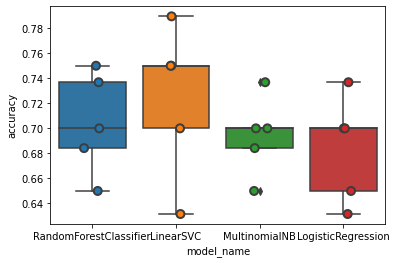

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.724211
LogisticRegression        0.683684
MultinomialNB             0.694211
RandomForestClassifier    0.704211
Name: accuracy, dtype: float64

Model Evaluation

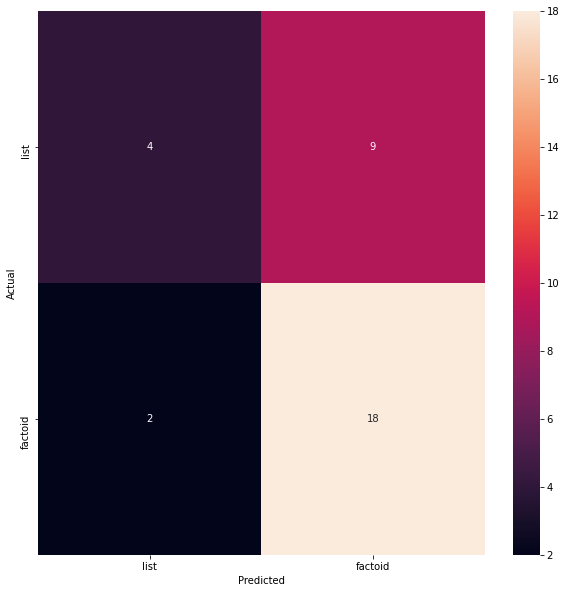

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Labels.values, yticklabels=category_id_df.Labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Labels'].unique()))

              precision    recall  f1-score   support

        list       0.67      0.31      0.42        13
     factoid       0.67      0.90      0.77        20

    accuracy                           0.67        33
   macro avg       0.67      0.60      0.59        33
weighted avg       0.67      0.67      0.63        33

